# 🏥 GTV Segmentation Training Pipeline

## Mô tả
Notebook này thực hiện đầy đủ quy trình xử lý dữ liệu và huấn luyện mô hình U-Net cho bài toán phân đoạn khối u (GTV Segmentation).

### Quy trình:
1. **Cell 1-2**: Import thư viện và cấu hình
2. **Cell 3-5**: Xử lý và chuyển đổi dữ liệu (NIfTI → HDF5)
3. **Cell 6-7**: Tạo DataLoader cho training và validation
4. **Cell 8-9**: Định nghĩa model U-Net và loss functions
5. **Cell 10-12**: Training loop với validation
6. **Cell 13-14**: Đánh giá model và visualization

---

## 1. Import Libraries

In [1]:
!pip install torch>=1.13 numpy>=1.23 h5py>=3.8 SimpleITK>=2.2 scipy>=1.10 tqdm>=4.60 medpy>=0.4.0 tensorboardX>=2.6 matplotlib


In [13]:
# Standard libraries
import os
import sys
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Callable, Iterable, Sequence
import warnings
warnings.filterwarnings('ignore')

# Data processing
import numpy as np
import h5py
import SimpleITK as sitk
from scipy import ndimage
from scipy.ndimage import zoom

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt

# Progress bar - sử dụng tqdm.auto để tự động chọn phiên bản phù hợp
# Nếu ipywidgets không có sẵn, sẽ fallback về text-based progress bar
# try:
#     from tqdm.notebook import tqdm
# except ImportError:
from tqdm import tqdm
    # print("⚠️ ipywidgets not installed. Using text-based progress bar.")

# Metrics
from medpy import metric

# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 5090
GPU Memory: 33.67 GB


## 2. Configuration

In [14]:
@dataclass
class Config:
    """Cấu hình cho toàn bộ pipeline"""
    
    # === Đường dẫn dữ liệu ===
    # Thư mục chứa dữ liệu gốc (NIfTI files)
    # Cấu trúc: dataset_root/center_name/images/*.nii.gz và labels/*.nii.gz
    dataset_root: str = "/home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/TMI2024_SFADA_GTV_Seg-20251026T074626Z-1-001/TMI2024_SFADA_GTV_Seg"
    
    # Thư mục output cho dữ liệu đã chuyển đổi (HDF5)
    output_root: str = "/home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/h5_dataset"
    
    # Thư mục lưu checkpoints và logs
    experiment_dir: str = "/home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/experiments/unet_notebook"
    
    # === Tiền xử lý dữ liệu ===
    clip_percentile: float = 0.99  # Percentile cho intensity clipping
    train_ratio: float = 0.7       # Tỷ lệ training set
    val_ratio: float = 0.2         # Tỷ lệ validation set
    test_ratio: float = 0.1        # Tỷ lệ test set
    
    # === Training ===
    batch_size: int = 4           # Giảm từ 32 xuống 4 để tiết kiệm GPU memory
    num_workers: int = 4           # Giảm từ 8 xuống 4 để tiết kiệm RAM
    max_epochs: int = 50           # Số epochs tối đa (thay vì max_iterations)
    base_lr: float = 0.03          # Learning rate ban đầu
    weight_decay: float = 1e-4     # Weight decay
    
    # === Model ===
    num_classes: int = 2           # Số classes (background + foreground)
    patch_size: Tuple[int, int] = (256, 256)  # Kích thước patch training
    
    # === Evaluation ===
    eval_every_epoch: int = 1      # Đánh giá mỗi N epochs (1 = mỗi epoch)
    save_every_epoch: int = 10     # Lưu checkpoint mỗi N epochs
    patience: int = 15             # Early stopping patience (số epochs không cải thiện)
    
    # === Misc ===
    seed: int = 2023               # Random seed
    device: str = "cuda"           # Device (cuda/cpu)


# Khởi tạo config
config = Config()

# Tạo thư mục output
Path(config.output_root).mkdir(parents=True, exist_ok=True)
Path(config.experiment_dir).mkdir(parents=True, exist_ok=True)

# Set random seed
torch.manual_seed(config.seed)
np.random.seed(config.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.seed)

# Giải phóng GPU memory trước khi bắt đầu
torch.cuda.empty_cache()

print("✅ Configuration loaded:")
print(f"   Dataset root: {config.dataset_root}")
print(f"   Output root: {config.output_root}")
print(f"   Experiment dir: {config.experiment_dir}")
print(f"   Batch size: {config.batch_size}")
print(f"   Max epochs: {config.max_epochs}")
print(f"   Eval every: {config.eval_every_epoch} epoch(s)")
print(f"   Early stopping patience: {config.patience} epochs")
print(f"   Patch size: {config.patch_size}")

# Hiển thị GPU memory
if torch.cuda.is_available():
    print(f"\n📊 GPU Memory:")
    print(f"   Total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"   Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"   Cached: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")

✅ Configuration loaded:
   Dataset root: /home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/TMI2024_SFADA_GTV_Seg-20251026T074626Z-1-001/TMI2024_SFADA_GTV_Seg
   Output root: /home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/h5_dataset
   Experiment dir: /home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/experiments/unet_notebook
   Batch size: 4
   Max epochs: 50
   Eval every: 1 epoch(s)
   Early stopping patience: 15 epochs
   Patch size: (256, 256)

📊 GPU Memory:
   Total: 33.67 GB
   Allocated: 0.01 GB
   Cached: 0.03 GB


## 3. Data Conversion Functions

Các hàm chuyển đổi dữ liệu từ định dạng NIfTI sang HDF5 để tối ưu tốc độ đọc.

In [15]:
# ============================================================
# DATA CONVERSION UTILITIES
# ============================================================

@dataclass
class CaseInfo:
    """Metadata cho một case thuộc một center cụ thể"""
    center: str
    image_path: Path
    label_path: Optional[Path]

    @property
    def base_name(self) -> str:
        name = self.image_path.name
        for suffix in reversed(self.image_path.suffixes):
            if name.endswith(suffix):
                name = name[:-len(suffix)]
        return name

    @property
    def identifier(self) -> str:
        return f"{self.center}_{self.base_name}"


def load_volume(image_path: Path, label_path: Optional[Path]) -> Tuple[np.ndarray, Optional[np.ndarray], Tuple[float, float, float]]:
    """Load NIfTI volume và trả về numpy array + spacing"""
    image_itk = sitk.ReadImage(str(image_path))
    image_array = sitk.GetArrayFromImage(image_itk).astype(np.float32)
    spacing = image_itk.GetSpacing()

    label_array = None
    if label_path is not None and label_path.exists():
        label_itk = sitk.ReadImage(str(label_path))
        label_array = sitk.GetArrayFromImage(label_itk).astype(np.int16)
    return image_array, label_array, spacing


def intensity_clip(volume: np.ndarray, percentile: float = 0.99) -> np.ndarray:
    """Clip intensity values tại percentile để loại bỏ outliers"""
    threshold = np.quantile(volume.reshape(-1), percentile)
    return np.clip(volume, volume.min(), threshold)


def z_score_normalise(volume: np.ndarray, epsilon: float = 1e-6) -> np.ndarray:
    """Z-score normalization"""
    mean = float(volume.mean())
    std = float(volume.std())
    if std < epsilon:
        std = epsilon
    return (volume - mean) / std


def ensure_dir(path: Path) -> None:
    """Tạo thư mục nếu chưa tồn tại"""
    path.mkdir(parents=True, exist_ok=True)


def write_slice_h5(output_path: Path, image_slice: np.ndarray, label_slice: Optional[np.ndarray]) -> None:
    """Lưu một slice 2D dưới dạng HDF5"""
    ensure_dir(output_path.parent)
    with h5py.File(output_path, "w") as f:
        f.create_dataset("image", data=image_slice.astype(np.float32), compression="gzip")
        if label_slice is not None:
            f.create_dataset("label", data=label_slice.astype(np.int16), compression="gzip")


def write_volume_h5(output_path: Path, image_volume: np.ndarray, label_volume: Optional[np.ndarray], 
                    spacing: Tuple[float, float, float]) -> None:
    """Lưu toàn bộ volume 3D dưới dạng HDF5"""
    ensure_dir(output_path.parent)
    with h5py.File(output_path, "w") as f:
        f.create_dataset("image", data=image_volume.astype(np.float32), compression="gzip")
        if label_volume is not None:
            f.create_dataset("label", data=label_volume.astype(np.int16), compression="gzip")
        f.create_dataset("voxel_spacing", data=np.asarray(spacing, dtype=np.float32), compression="gzip")


def gather_cases_by_center(dataset_root: Path) -> Dict[str, List[CaseInfo]]:
    """Quét thư mục và thu thập thông tin các cases theo center"""
    centers: Dict[str, List[CaseInfo]] = {}
    for center_dir in sorted(dataset_root.iterdir()):
        if not center_dir.is_dir():
            continue
        image_dir = center_dir / "images"
        label_dir = center_dir / "labels"
        if not image_dir.exists():
            continue
        cases: List[CaseInfo] = []
        for image_path in sorted(image_dir.glob("*.nii*")):
            label_path = label_dir / image_path.name if label_dir.exists() else None
            if label_path is not None and not label_path.exists():
                print(f"⚠️ Missing label for {image_path}")
                continue
            cases.append(CaseInfo(center=center_dir.name, image_path=image_path, label_path=label_path))
        if cases:
            centers[center_dir.name] = cases
    if not centers:
        raise FileNotFoundError(f"No centers found in {dataset_root}")
    return centers


def split_cases_by_ratio(centers: Dict[str, List[CaseInfo]], ratios: Sequence[float], seed: int) -> Tuple[List[CaseInfo], List[CaseInfo], List[CaseInfo]]:
    """Chia cases thành train/val/test theo tỷ lệ, đảm bảo mỗi center đều có đại diện"""
    rng = np.random.default_rng(seed)
    train_cases, val_cases, test_cases = [], [], []

    for center, cases in centers.items():
        indices = rng.permutation(len(cases))
        raw = np.array(ratios) * len(cases)
        counts = np.floor(raw).astype(int)
        remainder = len(cases) - counts.sum()
        if remainder > 0:
            order = np.argsort(raw - counts)[::-1]
            for idx in order[:remainder]:
                counts[idx] += 1
        
        train_n, val_n, test_n = counts
        train_cases.extend(cases[i] for i in indices[:train_n])
        val_cases.extend(cases[i] for i in indices[train_n:train_n + val_n])
        test_cases.extend(cases[i] for i in indices[train_n + val_n:train_n + val_n + test_n])

    return train_cases, val_cases, test_cases


print("✅ Data conversion functions defined")

✅ Data conversion functions defined


## 4. Convert NIfTI to HDF5

Chuyển đổi dữ liệu từ NIfTI sang HDF5:
- **Training set**: Lưu từng slice 2D riêng biệt (để shuffle dễ dàng)
- **Val/Test set**: Lưu toàn bộ volume 3D (để đánh giá chính xác)

In [5]:
def convert_data(config: Config, force_reconvert: bool = False):
    """
    Chuyển đổi dữ liệu NIfTI sang HDF5
    
    Args:
        config: Configuration object
        force_reconvert: Nếu True, sẽ xóa và chuyển đổi lại toàn bộ
    """
    output_root = Path(config.output_root)
    training_dir = output_root / "training_set"
    val_dir = output_root / "val_set"
    test_dir = output_root / "test_set"
    
    # Kiểm tra xem đã convert chưa
    if not force_reconvert and training_dir.exists() and len(list(training_dir.glob("*.h5"))) > 0:
        n_train = len(list(training_dir.glob("*.h5")))
        n_val = len(list(val_dir.glob("*.h5"))) if val_dir.exists() else 0
        n_test = len(list(test_dir.glob("*.h5"))) if test_dir.exists() else 0
        print(f"✅ Data already converted:")
        print(f"   Training slices: {n_train}")
        print(f"   Validation volumes: {n_val}")
        print(f"   Test volumes: {n_test}")
        return
    
    print("🔄 Starting data conversion...")
    
    # Thu thập cases
    dataset_root = Path(config.dataset_root)
    centers = gather_cases_by_center(dataset_root)
    
    print(f"\n📊 Found {len(centers)} centers:")
    for center, cases in centers.items():
        print(f"   {center}: {len(cases)} cases")
    
    # Chia train/val/test
    ratios = (config.train_ratio, config.val_ratio, config.test_ratio)
    train_cases, val_cases, test_cases = split_cases_by_ratio(centers, ratios, config.seed)
    
    print(f"\n📊 Split: {len(train_cases)} train, {len(val_cases)} val, {len(test_cases)} test")
    
    # Lưu split lists
    splits_dir = output_root / "splits"
    ensure_dir(splits_dir)
    for split_name, cases in [("train", train_cases), ("val", val_cases), ("test", test_cases)]:
        with open(splits_dir / f"{split_name}.txt", "w") as f:
            for case in cases:
                f.write(case.identifier + "\n")
    
    # Convert training cases (save as 2D slices)
    print("\n🔄 Converting training cases to 2D slices...")
    ensure_dir(training_dir)
    total_slices = 0
    
    for case in tqdm(train_cases, desc="Training cases"):
        image_volume, label_volume, _ = load_volume(case.image_path, case.label_path)
        image_volume = z_score_normalise(intensity_clip(image_volume, config.clip_percentile))
        
        for idx in range(image_volume.shape[0]):
            slice_id = f"{case.identifier}_slice_{idx:03d}.h5"
            write_slice_h5(training_dir / slice_id, image_volume[idx], label_volume[idx])
            total_slices += 1
    
    print(f"   ✅ Saved {total_slices} training slices")
    
    # Convert validation cases (save as 3D volumes)
    print("\n🔄 Converting validation cases to 3D volumes...")
    ensure_dir(val_dir)
    for case in tqdm(val_cases, desc="Validation cases"):
        image_volume, label_volume, spacing = load_volume(case.image_path, case.label_path)
        image_volume = z_score_normalise(intensity_clip(image_volume, config.clip_percentile))
        write_volume_h5(val_dir / f"{case.identifier}.h5", image_volume, label_volume, spacing)
    print(f"   ✅ Saved {len(val_cases)} validation volumes")
    
    # Convert test cases (save as 3D volumes)
    if test_cases:
        print("\n🔄 Converting test cases to 3D volumes...")
        ensure_dir(test_dir)
        for case in tqdm(test_cases, desc="Test cases"):
            image_volume, label_volume, spacing = load_volume(case.image_path, case.label_path)
            image_volume = z_score_normalise(intensity_clip(image_volume, config.clip_percentile))
            write_volume_h5(test_dir / f"{case.identifier}.h5", image_volume, label_volume, spacing)
        print(f"   ✅ Saved {len(test_cases)} test volumes")
    
    print("\n✅ Data conversion complete!")


# Thực hiện chuyển đổi (set force_reconvert=True để convert lại)
convert_data(config, force_reconvert=False)

✅ Data already converted:
   Training slices: 5242
   Validation volumes: 32
   Test volumes: 16


## 5. Dataset Classes

Định nghĩa các Dataset classes cho PyTorch DataLoader:
- `H5SliceDataset`: Cho training (2D slices với augmentation)
- `H5VolumeDataset`: Cho validation/test (3D volumes)

In [16]:
# ============================================================
# AUGMENTATION FUNCTIONS
# ============================================================

def random_rot_flip(image: np.ndarray, label: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Random rotation (0, 90, 180, 270 degrees) và flip"""
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    label = np.rot90(label, k)
    if np.random.rand() > 0.5:
        axis = np.random.randint(0, 2)
        image = np.flip(image, axis=axis).copy()
        label = np.flip(label, axis=axis).copy()
    return image, label


def random_rotate(image: np.ndarray, label: np.ndarray, angle_limit: int = 20) -> Tuple[np.ndarray, np.ndarray]:
    """Random rotation trong khoảng [-angle_limit, angle_limit] degrees"""
    angle = np.random.randint(-angle_limit, angle_limit + 1)
    if angle == 0:
        return image, label
    rotated_image = ndimage.rotate(image, angle, order=0, reshape=False)
    rotated_label = ndimage.rotate(label, angle, order=0, reshape=False)
    return rotated_image, rotated_label


def random_noise(image: np.ndarray, label: np.ndarray, sigma: float = 0.1) -> Tuple[np.ndarray, np.ndarray]:
    """Add Gaussian noise"""
    noise = np.clip(sigma * np.random.randn(*image.shape), -2 * sigma, 2 * sigma)
    return image + noise, label


# ============================================================
# DATASET CLASSES
# ============================================================

class H5SliceDataset(Dataset):
    """Dataset cho 2D slices (training)"""

    def __init__(self, root_dir: str, patch_size: Optional[Tuple[int, int]] = None, augment: bool = False):
        self.root_dir = Path(root_dir)
        self.files = sorted(self.root_dir.glob("*.h5"))
        if not self.files:
            raise FileNotFoundError(f"No HDF5 slices found in {self.root_dir}")
        self.patch_size = patch_size
        self.augment = augment

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        file_path = self.files[index]
        with h5py.File(file_path, "r") as f:
            image = f["image"][:].astype(np.float32)
            label = f["label"][:].astype(np.int64)

        # Augmentation
        if self.augment:
            if np.random.rand() > 0.5:
                image, label = random_rot_flip(image, label)
            if np.random.rand() > 0.5:
                image, label = random_rotate(image, label)
            if np.random.rand() > 0.5:
                image, label = random_noise(image, label)

        # Resize về patch_size
        if self.patch_size is not None:
            h, w = image.shape
            image = zoom(image, (self.patch_size[0] / h, self.patch_size[1] / w), order=0)
            label = zoom(label, (self.patch_size[0] / h, self.patch_size[1] / w), order=0)

        # Binary label
        label = np.rint(label).astype(np.int64)
        label[label > 0] = 1

        return {
            "image": torch.from_numpy(np.ascontiguousarray(image[np.newaxis, ...])),
            "label": torch.from_numpy(np.ascontiguousarray(label)).long(),
            "name": file_path.stem,
        }


class H5VolumeDataset(Dataset):
    """Dataset cho 3D volumes (validation/test)"""

    def __init__(self, root_dir: str):
        self.root_dir = Path(root_dir)
        self.files = sorted(self.root_dir.glob("*.h5"))
        if not self.files:
            raise FileNotFoundError(f"No HDF5 volumes found in {self.root_dir}")

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        file_path = self.files[index]
        with h5py.File(file_path, "r") as f:
            image = f["image"][:].astype(np.float32)      # (D, H, W)
            label = f["label"][:].astype(np.int64) if "label" in f else None
            spacing = f["voxel_spacing"][:].astype(np.float32)

        # Binary label
        if label is not None:
            label = np.rint(label).astype(np.int64)
            label[label > 0] = 1

        # Thêm channel dimension: [D, H, W] -> [1, D, H, W]
        image_tensor = torch.from_numpy(np.ascontiguousarray(image[np.newaxis, ...]))
        label_tensor = torch.from_numpy(np.ascontiguousarray(label)).long() if label is not None else None
        spacing_tensor = torch.from_numpy(np.ascontiguousarray(spacing))

        return {
            "image": image_tensor,      # (1, D, H, W)
            "label": label_tensor,      # (D, H, W)
            "spacing": spacing_tensor,  # (3,)
            "name": file_path.stem,
        }


print("✅ Dataset classes defined")

✅ Dataset classes defined


## 6. Create DataLoaders

Tạo DataLoader cho training và validation.

In [17]:
# Tạo datasets
train_dataset = H5SliceDataset(
    Path(config.output_root) / "training_set",
    patch_size=config.patch_size,
    augment=True,
)
val_dataset = H5VolumeDataset(Path(config.output_root) / "val_set")

print(f"📊 Training dataset: {len(train_dataset)} slices")
print(f"📊 Validation dataset: {len(val_dataset)} volumes")

# Worker init function để đảm bảo reproducibility
def worker_init_fn(worker_id):
    np.random.seed(config.seed + worker_id)

# Tạo DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True,
    worker_init_fn=worker_init_fn
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=1, 
    shuffle=False, 
    num_workers=1
)

print(f"\n📊 Iterations per epoch: {len(train_loader)}")
print(f"📊 Max epochs: {config.max_epochs}")

📊 Training dataset: 5242 slices
📊 Validation dataset: 32 volumes

📊 Iterations per epoch: 1311
📊 Max epochs: 50


## 7. Visualize Sample Data

Hiển thị một vài mẫu dữ liệu để kiểm tra.

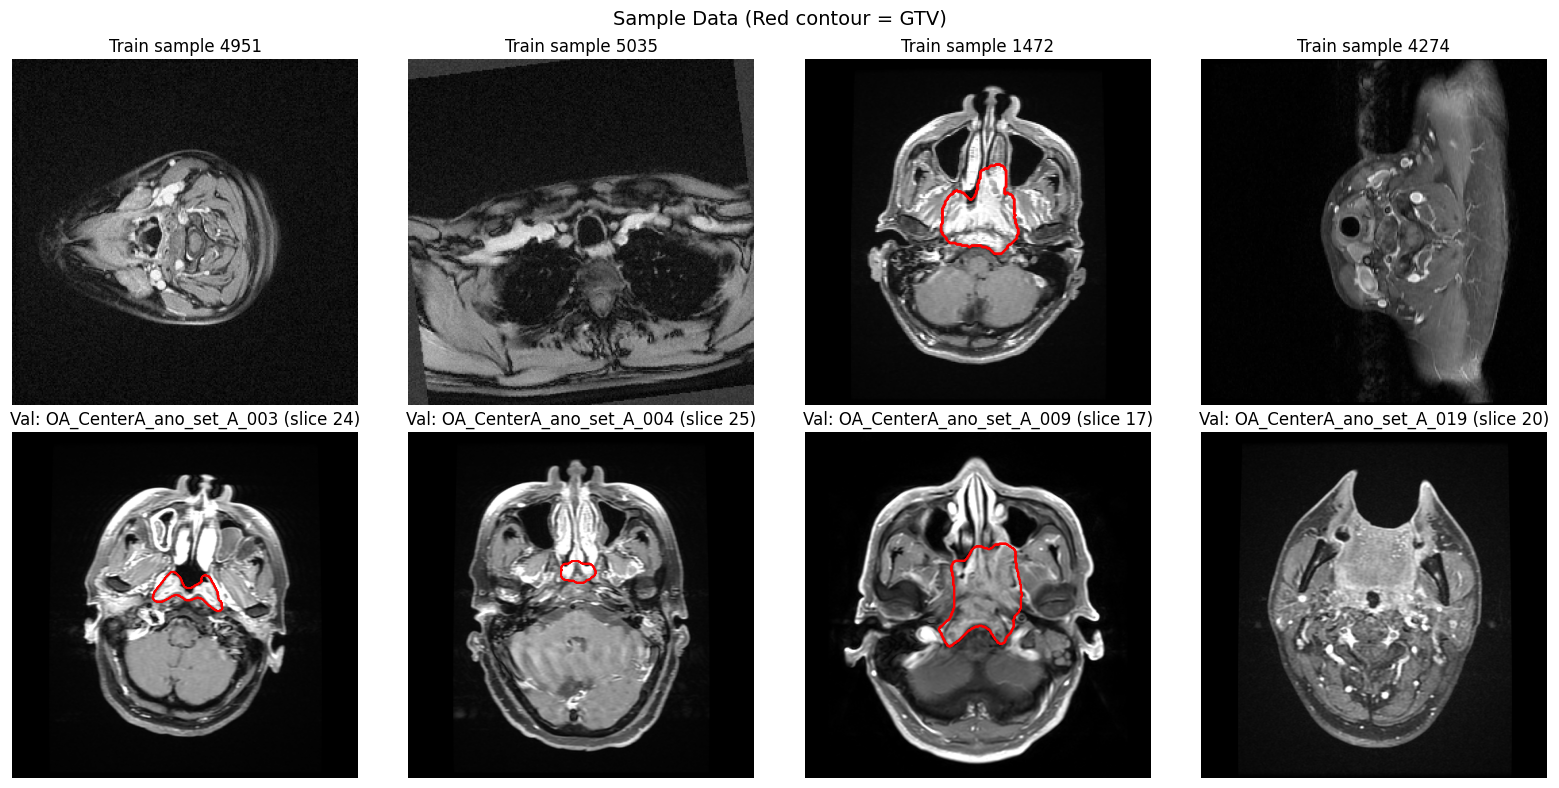

In [8]:
# Visualize một vài samples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Training samples
for i in range(4):
    idx = np.random.randint(0, len(train_dataset))
    sample = train_dataset[idx]
    image = sample["image"].numpy().squeeze()
    label = sample["label"].numpy()
    
    axes[0, i].imshow(image, cmap="gray")
    axes[0, i].contour(label, colors="red", linewidths=1)
    axes[0, i].set_title(f"Train sample {idx}")
    axes[0, i].axis("off")

# Validation sample (middle slice)
for i in range(4):
    if i < len(val_dataset):
        sample = val_dataset[i]
        image = sample["image"].numpy().squeeze()  # (D, H, W)
        label = sample["label"].numpy()            # (D, H, W)
        
        mid_slice = image.shape[0] // 2
        axes[1, i].imshow(image[mid_slice], cmap="gray")
        axes[1, i].contour(label[mid_slice], colors="red", linewidths=1)
        axes[1, i].set_title(f"Val: {sample['name']} (slice {mid_slice})")
        axes[1, i].axis("off")

plt.suptitle("Sample Data (Red contour = GTV)", fontsize=14)
plt.tight_layout()
plt.show()

## 8. Define U-Net Model

Kiến trúc U-Net với:
- Encoder: 4 conv blocks với max pooling
- Bottleneck: 1 conv block
- Decoder: 4 conv blocks với skip connections
- Dropout tăng dần theo độ sâu

In [18]:
# ============================================================
# U-NET MODEL
# ============================================================

def conv_block(in_channels: int, out_channels: int, dropout_p: float = 0.0) -> nn.Sequential:
    """Two convolution layers with batch norm, leaky relu and dropout"""
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(),
        nn.Dropout(dropout_p),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )


class UNet(nn.Module):
    def __init__(self, in_channels: int = 1, num_classes: int = 2, base_width: int = 16):
        super().__init__()
        # Feature channels: [16, 32, 64, 128, 256]
        filters = [base_width * 2**i for i in range(5)]
        # Dropout tăng dần theo độ sâu
        dropouts = [0.05, 0.1, 0.2, 0.3, 0.5]

        # Encoder
        self.encoder1 = conv_block(in_channels, filters[0], dropouts[0])    # 1 → 16
        self.encoder2 = conv_block(filters[0], filters[1], dropouts[1])     # 16 → 32
        self.encoder3 = conv_block(filters[1], filters[2], dropouts[2])     # 32 → 64
        self.encoder4 = conv_block(filters[2], filters[3], dropouts[3])     # 64 → 128
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = conv_block(filters[3], filters[4], dropouts[4])   # 128 → 256

        # Decoder
        self.up4 = nn.ConvTranspose2d(filters[4], filters[3], kernel_size=2, stride=2)
        self.decoder4 = conv_block(filters[3] * 2, filters[3], dropout_p=0.0)

        self.up3 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=2)
        self.decoder3 = conv_block(filters[2] * 2, filters[2], dropout_p=0.0)

        self.up2 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
        self.decoder2 = conv_block(filters[1] * 2, filters[1], dropout_p=0.0)

        self.up1 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        self.decoder1 = conv_block(filters[0] * 2, filters[0], dropout_p=0.0)

        # Classifier
        self.classifier = nn.Conv2d(filters[0], num_classes, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Encoder path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder path với skip connections
        dec4 = self.up4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.up3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.up2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.up1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)

        return self.classifier(dec1)


# Tạo model
model = UNet(in_channels=1, num_classes=config.num_classes)
device = torch.device(config.device if torch.cuda.is_available() else "cpu")
model.to(device)

# Đếm parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ U-Net model created")
print(f"   Device: {device}")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

✅ U-Net model created
   Device: cuda
   Total parameters: 1,943,778
   Trainable parameters: 1,943,778


## 9. Loss Functions và Metrics

Định nghĩa:
- **Dice Loss**: Cho class imbalance
- **Cross-Entropy Loss**: Classification loss
- **Combined Loss**: 0.5 * (CE + Dice)
- **Metrics**: Dice, HD95, ASD, NSD

In [19]:
# ============================================================
# LOSS FUNCTIONS
# ============================================================

def dice_loss(score: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    Binary Dice loss
    
    Args:
        score: Softmax predictions cho foreground class [B, H, W]
        target: Ground truth labels [B, H, W]
    """
    target = target.float()
    smooth = 1e-5
    intersect = torch.sum(score * target)
    y_sum = torch.sum(target * target)
    z_sum = torch.sum(score * score)
    loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
    return 1 - loss


# Cross-Entropy Loss
ce_loss = nn.CrossEntropyLoss()

print("✅ Loss functions defined")


# ============================================================
# METRICS
# ============================================================

def calculate_metric_percase(pred: np.ndarray, gt: np.ndarray, 
                             spacing: Tuple[float, float, float] = (3.0, 0.5, 0.5)) -> Tuple:
    """
    Tính metrics cho một case
    
    Returns:
        Tuple of (dice, hd95, asd)
    """
    pred = pred.copy()
    gt = gt.copy()
    pred[pred > 0] = 1
    gt[gt > 0] = 1
    
    # Dice coefficient
    if pred.sum() > 0 and gt.sum() > 0:
        dice = metric.binary.dc(pred, gt)
    else:
        dice = 0.0
    
    # HD95 và ASD
    try:
        if pred.sum() > 0 and gt.sum() > 0:
            hd95 = metric.binary.hd95(pred, gt, voxelspacing=spacing)
            asd = metric.binary.asd(pred, gt, voxelspacing=spacing)
        else:
            hd95 = 0.0
            asd = 0.0
    except:
        hd95 = 0.0
        asd = 0.0
    
    return (dice, hd95, asd)


def test_single_volume(image: torch.Tensor, label: torch.Tensor, net: nn.Module,
                       classes: int, patch_size: List[int] = [256, 256], 
                       batch_size: int = 24) -> List:
    """
    Test một volume 3D với batch processing
    
    Args:
        image: Tensor shape [1, 1, D, H, W] hoặc [1, D, H, W]
        label: Tensor shape [1, D, H, W] hoặc [D, H, W]
        net: Model để inference
        classes: Số lượng classes
        patch_size: Kích thước patch để resize
        batch_size: Số slices xử lý cùng lúc
    """
    # Chuyển về numpy
    image = image.squeeze(0).cpu().detach().numpy()
    label = label.squeeze(0).cpu().detach().numpy()
    
    if image.ndim == 4:
        image = image.squeeze(0)
    
    prediction = np.zeros_like(label)
    
    # Xử lý theo batch
    for ind in range(0, image.shape[0], batch_size):
        end_ind = min(ind + batch_size, image.shape[0])
        stacked_slices = image[ind:end_ind, ...]
        z, x, y = stacked_slices.shape[0], stacked_slices.shape[1], stacked_slices.shape[2]
        
        # Zoom về patch_size
        zoomed_slices = zoom(stacked_slices, (1, patch_size[0] / x, patch_size[1] / y), order=0)
        input_tensor = torch.from_numpy(zoomed_slices).unsqueeze(1).float().to(device)
        
        # Inference
        net.eval()
        with torch.no_grad():
            out = torch.argmax(torch.softmax(net(input_tensor), dim=1), dim=1)
            out = out.cpu().detach().numpy()
            
            # Zoom về kích thước gốc
            pred = zoom(out, (1, x / patch_size[0], y / patch_size[1]), order=0)
            prediction[ind:end_ind, ...] = pred
    
    # Tính metrics cho từng class (bỏ background)
    metric_list = []
    for i in range(1, classes):
        metric_i = calculate_metric_percase(prediction == i, label == i)
        metric_list.append(metric_i)
    
    return metric_list


print("✅ Metrics functions defined")

✅ Loss functions defined
✅ Metrics functions defined


## 10. Training Setup

Khởi tạo optimizer và các biến training.

In [20]:
# ============================================================
# TRAINING SETUP
# ============================================================

# Optimizer với SGD + momentum (giống Code_OA)
optimizer = optim.SGD(
    model.parameters(), 
    lr=config.base_lr, 
    momentum=0.9, 
    weight_decay=config.weight_decay
)

# Training variables
best_performance = 0.0
best_epoch = 0
iter_num = 0
patience_counter = 0
early_stop = False

# Tính tổng số iterations
total_iterations = config.max_epochs * len(train_loader)

# History để plot (theo epoch)
history = {
    'epoch': [],
    'train_loss': [],      # Average loss per epoch
    'lr': [],
    'val_dice': [],
    'val_hd95': [],
    'val_asd': [],
}

print("✅ Training setup complete")
print(f"   Optimizer: SGD (lr={config.base_lr}, momentum=0.9)")
print(f"   Max epochs: {config.max_epochs}")
print(f"   Iterations per epoch: {len(train_loader)}")
print(f"   Total iterations: {total_iterations}")
print(f"   Eval every: {config.eval_every_epoch} epoch(s)")
print(f"   Save checkpoint every: {config.save_every_epoch} epoch(s)")
print(f"   Early stopping patience: {config.patience} epochs")

✅ Training setup complete
   Optimizer: SGD (lr=0.03, momentum=0.9)
   Max epochs: 50
   Iterations per epoch: 1311
   Total iterations: 65550
   Eval every: 1 epoch(s)
   Save checkpoint every: 10 epoch(s)
   Early stopping patience: 15 epochs


## 11. Training Loop (Epoch-based)

Vòng lặp huấn luyện với đánh giá **theo epoch**:
- ✅ Đánh giá cuối mỗi epoch (sau khi model thấy toàn bộ training data)
- ✅ Lưu best model khi Dice cải thiện
- ✅ Early stopping nếu không cải thiện sau N epochs
- ✅ Polynomial learning rate decay

In [12]:
# ============================================================
# TRAINING LOOP (EPOCH-BASED EVALUATION)
# ============================================================

experiment_dir = Path(config.experiment_dir)
experiment_dir.mkdir(parents=True, exist_ok=True)

print("🚀 Starting training...")
print("=" * 60)

for epoch_num in range(1, config.max_epochs + 1):
    model.train()
    epoch_loss = 0.0
    num_batches = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch_num}/{config.max_epochs}", leave=True)
    
    for batch in pbar:
        images = batch["image"].to(device).float()
        labels = batch["label"].to(device)

        # Forward pass
        logits = model(images)
        outputs_soft = torch.softmax(logits, dim=1)
        
        # Combined loss: 0.5 * (CE + Dice)
        loss = 0.5 * (ce_loss(logits, labels.long()) + dice_loss(outputs_soft[:, 1, ...], labels))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iter_num += 1
        epoch_loss += loss.item()
        num_batches += 1
        
        # Learning rate decay: polynomial decay (based on total iterations)
        lr_ = config.base_lr * (1.0 - iter_num / total_iterations) ** 0.9
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr_

        # Update progress bar
        pbar.set_postfix({"Loss": f"{loss.item():.4f}", "LR": f"{lr_:.6f}"})

    # ============================================================
    # END OF EPOCH: Calculate average loss
    # ============================================================
    avg_epoch_loss = epoch_loss / num_batches
    
    # ============================================================
    # VALIDATION (mỗi eval_every_epoch epochs)
    # ============================================================
    if epoch_num % config.eval_every_epoch == 0:
        model.eval()
        metric_list = []
        
        print(f"\n📊 Epoch {epoch_num} - Validating...")
        
        with torch.no_grad():
            for val_batch in tqdm(val_loader, desc="Validation", leave=False):
                metric_i = test_single_volume(
                    val_batch["image"],
                    val_batch["label"],
                    model,
                    classes=config.num_classes,
                    patch_size=list(config.patch_size),
                    batch_size=24
                )
                metric_list.append(metric_i)
        
        # Average metrics
        metric_array = np.array(metric_list)  # [num_val, num_classes-1, num_metrics]
        mean_metrics = np.mean(metric_array, axis=0)  # [num_classes-1, num_metrics]
        
        # Extract metrics
        dice_score = float(mean_metrics[0, 0])
        hd95_score = float(mean_metrics[0, 1])
        asd_score = float(mean_metrics[0, 2])
        
        # Log history
        history['epoch'].append(epoch_num)
        history['train_loss'].append(avg_epoch_loss)
        history['lr'].append(lr_)
        history['val_dice'].append(dice_score)
        history['val_hd95'].append(hd95_score)
        history['val_asd'].append(asd_score)
        
        print(f"   Train Loss: {avg_epoch_loss:.4f} | Val Dice: {dice_score:.4f} | HD95: {hd95_score:.2f} | ASD: {asd_score:.2f}")

        # ============================================================
        # SAVE BEST MODEL
        # ============================================================
        if dice_score > best_performance:
            best_performance = dice_score
            best_epoch = epoch_num
            patience_counter = 0
            
            best_path = experiment_dir / "unet_best_model.pth"
            torch.save({
                "epoch": epoch_num,
                "iter": iter_num,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "dice": best_performance,
                "hd95": hd95_score,
                "asd": asd_score,
            }, best_path)
            print(f"   ✅ New best model saved! (Epoch {epoch_num}, Dice: {best_performance:.4f})")
        else:
            patience_counter += 1
            print(f"   ⏳ No improvement. Patience: {patience_counter}/{config.patience}")
            
            if config.patience > 0 and patience_counter >= config.patience:
                print(f"\n   ⚠️ Early stopping triggered after {epoch_num} epochs!")
                print(f"   Best model was at epoch {best_epoch} with Dice: {best_performance:.4f}")
                early_stop = True

        model.train()
    
    # ============================================================
    # SAVE PERIODIC CHECKPOINT
    # ============================================================
    if epoch_num % config.save_every_epoch == 0:
        save_path = experiment_dir / f"model_epoch_{epoch_num}.pth"
        torch.save({
            "epoch": epoch_num,
            "iter": iter_num,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "dice": best_performance,
        }, save_path)
        print(f"💾 Checkpoint saved: {save_path.name}")
    
    if early_stop:
        break

# ============================================================
# SAVE FINAL MODEL
# ============================================================
final_path = experiment_dir / "last_model.pth"
torch.save({
    "epoch": epoch_num,
    "iter": iter_num,
    "state_dict": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "dice": best_performance,
}, final_path)

print("\n" + "=" * 60)
print("✅ Training complete!")
print(f"   Total epochs: {epoch_num}")
print(f"   Total iterations: {iter_num}")
print(f"   Best epoch: {best_epoch}")
print(f"   Best validation Dice: {best_performance:.4f}")
print(f"   Checkpoints saved to: {experiment_dir}")

🚀 Starting training...


Epoch 1/50: 100%|██████████| 1311/1311 [00:11<00:00, 113.76it/s, Loss=0.5088, LR=0.029459]



📊 Epoch 1 - Validating...


   Train Loss: 0.3817 | Val Dice: 0.2731 | HD95: 58.47 | ASD: 25.15
   ✅ New best model saved! (Epoch 1, Dice: 0.2731)


Epoch 2/50: 100%|██████████| 1311/1311 [00:11<00:00, 114.62it/s, Loss=0.4534, LR=0.028918]



📊 Epoch 2 - Validating...


   Train Loss: 0.3096 | Val Dice: 0.4897 | HD95: 14.41 | ASD: 2.85
   ✅ New best model saved! (Epoch 2, Dice: 0.4897)


Epoch 3/50: 100%|██████████| 1311/1311 [00:11<00:00, 117.37it/s, Loss=0.4988, LR=0.028375]



📊 Epoch 3 - Validating...


   Train Loss: 0.2968 | Val Dice: 0.6272 | HD95: 24.89 | ASD: 7.37
   ✅ New best model saved! (Epoch 3, Dice: 0.6272)


Epoch 4/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.16it/s, Loss=0.0965, LR=0.027831]



📊 Epoch 4 - Validating...


   Train Loss: 0.2907 | Val Dice: 0.3262 | HD95: 37.76 | ASD: 15.65
   ⏳ No improvement. Patience: 1/15


Epoch 5/50: 100%|██████████| 1311/1311 [00:11<00:00, 114.84it/s, Loss=0.5028, LR=0.027286]



📊 Epoch 5 - Validating...


   Train Loss: 0.2777 | Val Dice: 0.6373 | HD95: 13.63 | ASD: 4.31
   ✅ New best model saved! (Epoch 5, Dice: 0.6373)


Epoch 6/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.16it/s, Loss=0.2716, LR=0.026740]



📊 Epoch 6 - Validating...


   Train Loss: 0.2739 | Val Dice: 0.6689 | HD95: 9.95 | ASD: 2.82
   ✅ New best model saved! (Epoch 6, Dice: 0.6689)


Epoch 7/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.40it/s, Loss=0.5032, LR=0.026192]



📊 Epoch 7 - Validating...


   Train Loss: 0.2729 | Val Dice: 0.4616 | HD95: 36.34 | ASD: 12.99
   ⏳ No improvement. Patience: 1/15


Epoch 8/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.17it/s, Loss=0.5046, LR=0.025643]



📊 Epoch 8 - Validating...


   Train Loss: 0.2689 | Val Dice: 0.6441 | HD95: 29.55 | ASD: 9.19
   ⏳ No improvement. Patience: 2/15


Epoch 9/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.83it/s, Loss=0.0909, LR=0.025093]



📊 Epoch 9 - Validating...


   Train Loss: 0.2671 | Val Dice: 0.6585 | HD95: 18.24 | ASD: 6.00
   ⏳ No improvement. Patience: 3/15


Epoch 10/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.89it/s, Loss=0.5004, LR=0.024542]



📊 Epoch 10 - Validating...


   Train Loss: 0.2578 | Val Dice: 0.7089 | HD95: 10.26 | ASD: 3.09
   ✅ New best model saved! (Epoch 10, Dice: 0.7089)
💾 Checkpoint saved: model_epoch_10.pth


Epoch 11/50: 100%|██████████| 1311/1311 [00:11<00:00, 117.86it/s, Loss=0.5003, LR=0.023989]



📊 Epoch 11 - Validating...


   Train Loss: 0.2544 | Val Dice: 0.7134 | HD95: 9.53 | ASD: 2.64
   ✅ New best model saved! (Epoch 11, Dice: 0.7134)


Epoch 12/50: 100%|██████████| 1311/1311 [00:11<00:00, 117.17it/s, Loss=0.4972, LR=0.023434]



📊 Epoch 12 - Validating...


   Train Loss: 0.2567 | Val Dice: 0.5765 | HD95: 18.82 | ASD: 6.25
   ⏳ No improvement. Patience: 1/15


Epoch 13/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.84it/s, Loss=0.1211, LR=0.022879]



📊 Epoch 13 - Validating...


   Train Loss: 0.2565 | Val Dice: 0.7077 | HD95: 13.62 | ASD: 3.46
   ⏳ No improvement. Patience: 2/15


Epoch 14/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.87it/s, Loss=0.5005, LR=0.022321]



📊 Epoch 14 - Validating...


   Train Loss: 0.2492 | Val Dice: 0.6366 | HD95: 8.87 | ASD: 2.18
   ⏳ No improvement. Patience: 3/15


Epoch 15/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.79it/s, Loss=0.5003, LR=0.021763]



📊 Epoch 15 - Validating...


   Train Loss: 0.2434 | Val Dice: 0.7152 | HD95: 10.34 | ASD: 2.87
   ✅ New best model saved! (Epoch 15, Dice: 0.7152)


Epoch 16/50: 100%|██████████| 1311/1311 [00:11<00:00, 117.40it/s, Loss=0.5003, LR=0.021202]



📊 Epoch 16 - Validating...


   Train Loss: 0.2497 | Val Dice: 0.5601 | HD95: 24.66 | ASD: 8.31
   ⏳ No improvement. Patience: 1/15


Epoch 17/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.40it/s, Loss=0.0475, LR=0.020640]



📊 Epoch 17 - Validating...


   Train Loss: 0.2375 | Val Dice: 0.7005 | HD95: 13.58 | ASD: 4.23
   ⏳ No improvement. Patience: 2/15


Epoch 18/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.81it/s, Loss=0.5012, LR=0.020076]



📊 Epoch 18 - Validating...


   Train Loss: 0.2413 | Val Dice: 0.6347 | HD95: 22.36 | ASD: 6.43
   ⏳ No improvement. Patience: 3/15


Epoch 19/50: 100%|██████████| 1311/1311 [00:11<00:00, 114.63it/s, Loss=0.4999, LR=0.019511]



📊 Epoch 19 - Validating...


   Train Loss: 0.2384 | Val Dice: 0.7105 | HD95: 9.32 | ASD: 2.64
   ⏳ No improvement. Patience: 4/15


Epoch 20/50: 100%|██████████| 1311/1311 [00:11<00:00, 114.72it/s, Loss=0.5016, LR=0.018943]



📊 Epoch 20 - Validating...


   Train Loss: 0.2384 | Val Dice: 0.7477 | HD95: 7.64 | ASD: 2.32
   ✅ New best model saved! (Epoch 20, Dice: 0.7477)
💾 Checkpoint saved: model_epoch_20.pth


Epoch 21/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.25it/s, Loss=0.0555, LR=0.018374]



📊 Epoch 21 - Validating...


   Train Loss: 0.2383 | Val Dice: 0.7355 | HD95: 8.16 | ASD: 2.46
   ⏳ No improvement. Patience: 1/15


Epoch 22/50: 100%|██████████| 1311/1311 [00:11<00:00, 117.05it/s, Loss=0.0462, LR=0.017803]



📊 Epoch 22 - Validating...


   Train Loss: 0.2332 | Val Dice: 0.7103 | HD95: 12.56 | ASD: 3.82
   ⏳ No improvement. Patience: 2/15


Epoch 23/50: 100%|██████████| 1311/1311 [00:11<00:00, 114.69it/s, Loss=0.0723, LR=0.017230]



📊 Epoch 23 - Validating...


   Train Loss: 0.2315 | Val Dice: 0.6624 | HD95: 11.02 | ASD: 4.21
   ⏳ No improvement. Patience: 3/15


Epoch 24/50: 100%|██████████| 1311/1311 [00:11<00:00, 117.39it/s, Loss=0.5006, LR=0.016654]



📊 Epoch 24 - Validating...


   Train Loss: 0.2293 | Val Dice: 0.7262 | HD95: 11.22 | ASD: 3.54
   ⏳ No improvement. Patience: 4/15


Epoch 25/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.72it/s, Loss=0.1237, LR=0.016077]



📊 Epoch 25 - Validating...


   Train Loss: 0.2312 | Val Dice: 0.6977 | HD95: 13.39 | ASD: 4.20
   ⏳ No improvement. Patience: 5/15


Epoch 26/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.11it/s, Loss=0.5003, LR=0.015497]



📊 Epoch 26 - Validating...


   Train Loss: 0.2263 | Val Dice: 0.6808 | HD95: 15.59 | ASD: 5.10
   ⏳ No improvement. Patience: 6/15


Epoch 27/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.40it/s, Loss=0.0287, LR=0.014914]



📊 Epoch 27 - Validating...


   Train Loss: 0.2228 | Val Dice: 0.7114 | HD95: 12.14 | ASD: 3.85
   ⏳ No improvement. Patience: 7/15


Epoch 28/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.85it/s, Loss=0.5001, LR=0.014329]



📊 Epoch 28 - Validating...


   Train Loss: 0.2210 | Val Dice: 0.7349 | HD95: 7.68 | ASD: 2.26
   ⏳ No improvement. Patience: 8/15


Epoch 29/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.59it/s, Loss=0.5005, LR=0.013742]



📊 Epoch 29 - Validating...


   Train Loss: 0.2226 | Val Dice: 0.7464 | HD95: 8.37 | ASD: 2.45
   ⏳ No improvement. Patience: 9/15


Epoch 30/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.06it/s, Loss=0.0567, LR=0.013151]



📊 Epoch 30 - Validating...


   Train Loss: 0.2294 | Val Dice: 0.7544 | HD95: 8.05 | ASD: 2.59
   ✅ New best model saved! (Epoch 30, Dice: 0.7544)
💾 Checkpoint saved: model_epoch_30.pth


Epoch 31/50: 100%|██████████| 1311/1311 [00:11<00:00, 117.31it/s, Loss=0.5003, LR=0.012558]



📊 Epoch 31 - Validating...


   Train Loss: 0.2172 | Val Dice: 0.7038 | HD95: 18.87 | ASD: 5.34
   ⏳ No improvement. Patience: 1/15


Epoch 32/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.84it/s, Loss=0.5003, LR=0.011962]



📊 Epoch 32 - Validating...


   Train Loss: 0.2226 | Val Dice: 0.7797 | HD95: 7.01 | ASD: 2.32
   ✅ New best model saved! (Epoch 32, Dice: 0.7797)


Epoch 33/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.17it/s, Loss=0.5006, LR=0.011362]



📊 Epoch 33 - Validating...


   Train Loss: 0.2115 | Val Dice: 0.7273 | HD95: 14.96 | ASD: 4.26
   ⏳ No improvement. Patience: 1/15


Epoch 34/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.01it/s, Loss=0.0992, LR=0.010759]



📊 Epoch 34 - Validating...


   Train Loss: 0.2241 | Val Dice: 0.6989 | HD95: 9.80 | ASD: 3.70
   ⏳ No improvement. Patience: 2/15


Epoch 35/50: 100%|██████████| 1311/1311 [00:11<00:00, 114.92it/s, Loss=0.0971, LR=0.010152]



📊 Epoch 35 - Validating...


   Train Loss: 0.2168 | Val Dice: 0.7678 | HD95: 8.40 | ASD: 2.64
   ⏳ No improvement. Patience: 3/15


Epoch 36/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.12it/s, Loss=0.5005, LR=0.009540]



📊 Epoch 36 - Validating...


   Train Loss: 0.2181 | Val Dice: 0.7340 | HD95: 7.76 | ASD: 2.73
   ⏳ No improvement. Patience: 4/15


Epoch 37/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.21it/s, Loss=0.1780, LR=0.008925]



📊 Epoch 37 - Validating...


   Train Loss: 0.2149 | Val Dice: 0.7731 | HD95: 6.93 | ASD: 2.25
   ⏳ No improvement. Patience: 5/15


Epoch 38/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.52it/s, Loss=0.5004, LR=0.008304]



📊 Epoch 38 - Validating...


   Train Loss: 0.2099 | Val Dice: 0.7191 | HD95: 11.84 | ASD: 3.78
   ⏳ No improvement. Patience: 6/15


Epoch 39/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.49it/s, Loss=0.1844, LR=0.007679]



📊 Epoch 39 - Validating...


   Train Loss: 0.2160 | Val Dice: 0.7669 | HD95: 7.42 | ASD: 2.54
   ⏳ No improvement. Patience: 7/15


Epoch 40/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.60it/s, Loss=0.5002, LR=0.007048]



📊 Epoch 40 - Validating...


   Train Loss: 0.2083 | Val Dice: 0.7804 | HD95: 9.61 | ASD: 2.94
   ✅ New best model saved! (Epoch 40, Dice: 0.7804)
💾 Checkpoint saved: model_epoch_40.pth


Epoch 41/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.33it/s, Loss=0.2500, LR=0.006410]



📊 Epoch 41 - Validating...


   Train Loss: 0.2107 | Val Dice: 0.7831 | HD95: 6.20 | ASD: 2.04
   ✅ New best model saved! (Epoch 41, Dice: 0.7831)


Epoch 42/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.68it/s, Loss=0.5001, LR=0.005765]



📊 Epoch 42 - Validating...


   Train Loss: 0.2009 | Val Dice: 0.7877 | HD95: 7.03 | ASD: 2.41
   ✅ New best model saved! (Epoch 42, Dice: 0.7877)


Epoch 43/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.93it/s, Loss=0.0642, LR=0.005113]



📊 Epoch 43 - Validating...


   Train Loss: 0.2092 | Val Dice: 0.7688 | HD95: 9.24 | ASD: 2.69
   ⏳ No improvement. Patience: 1/15


Epoch 44/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.07it/s, Loss=0.0742, LR=0.004450]



📊 Epoch 44 - Validating...


   Train Loss: 0.2022 | Val Dice: 0.7948 | HD95: 6.25 | ASD: 1.84
   ✅ New best model saved! (Epoch 44, Dice: 0.7948)


Epoch 45/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.70it/s, Loss=0.1705, LR=0.003777]



📊 Epoch 45 - Validating...


   Train Loss: 0.2071 | Val Dice: 0.7790 | HD95: 7.36 | ASD: 2.28
   ⏳ No improvement. Patience: 1/15


Epoch 46/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.45it/s, Loss=0.0673, LR=0.003090]



📊 Epoch 46 - Validating...


   Train Loss: 0.1962 | Val Dice: 0.8024 | HD95: 6.67 | ASD: 2.06
   ✅ New best model saved! (Epoch 46, Dice: 0.8024)


Epoch 47/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.55it/s, Loss=0.5007, LR=0.002385]



📊 Epoch 47 - Validating...


   Train Loss: 0.1981 | Val Dice: 0.7965 | HD95: 6.79 | ASD: 2.14
   ⏳ No improvement. Patience: 1/15


Epoch 48/50: 100%|██████████| 1311/1311 [00:11<00:00, 117.01it/s, Loss=0.0466, LR=0.001656]



📊 Epoch 48 - Validating...


   Train Loss: 0.1960 | Val Dice: 0.8002 | HD95: 6.02 | ASD: 1.98
   ⏳ No improvement. Patience: 2/15


Epoch 49/50: 100%|██████████| 1311/1311 [00:11<00:00, 116.69it/s, Loss=0.5005, LR=0.000887]



📊 Epoch 49 - Validating...


   Train Loss: 0.2021 | Val Dice: 0.7965 | HD95: 6.71 | ASD: 2.15
   ⏳ No improvement. Patience: 3/15


Epoch 50/50: 100%|██████████| 1311/1311 [00:11<00:00, 115.35it/s, Loss=0.3195, LR=0.000000]



📊 Epoch 50 - Validating...


   Train Loss: 0.1967 | Val Dice: 0.7958 | HD95: 6.63 | ASD: 2.07
   ⏳ No improvement. Patience: 4/15
💾 Checkpoint saved: model_epoch_50.pth

✅ Training complete!
   Total epochs: 50
   Total iterations: 65550
   Best epoch: 46
   Best validation Dice: 0.8024
   Checkpoints saved to: /home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/experiments/unet_notebook


## 12. Plot Training History

Visualize quá trình training.

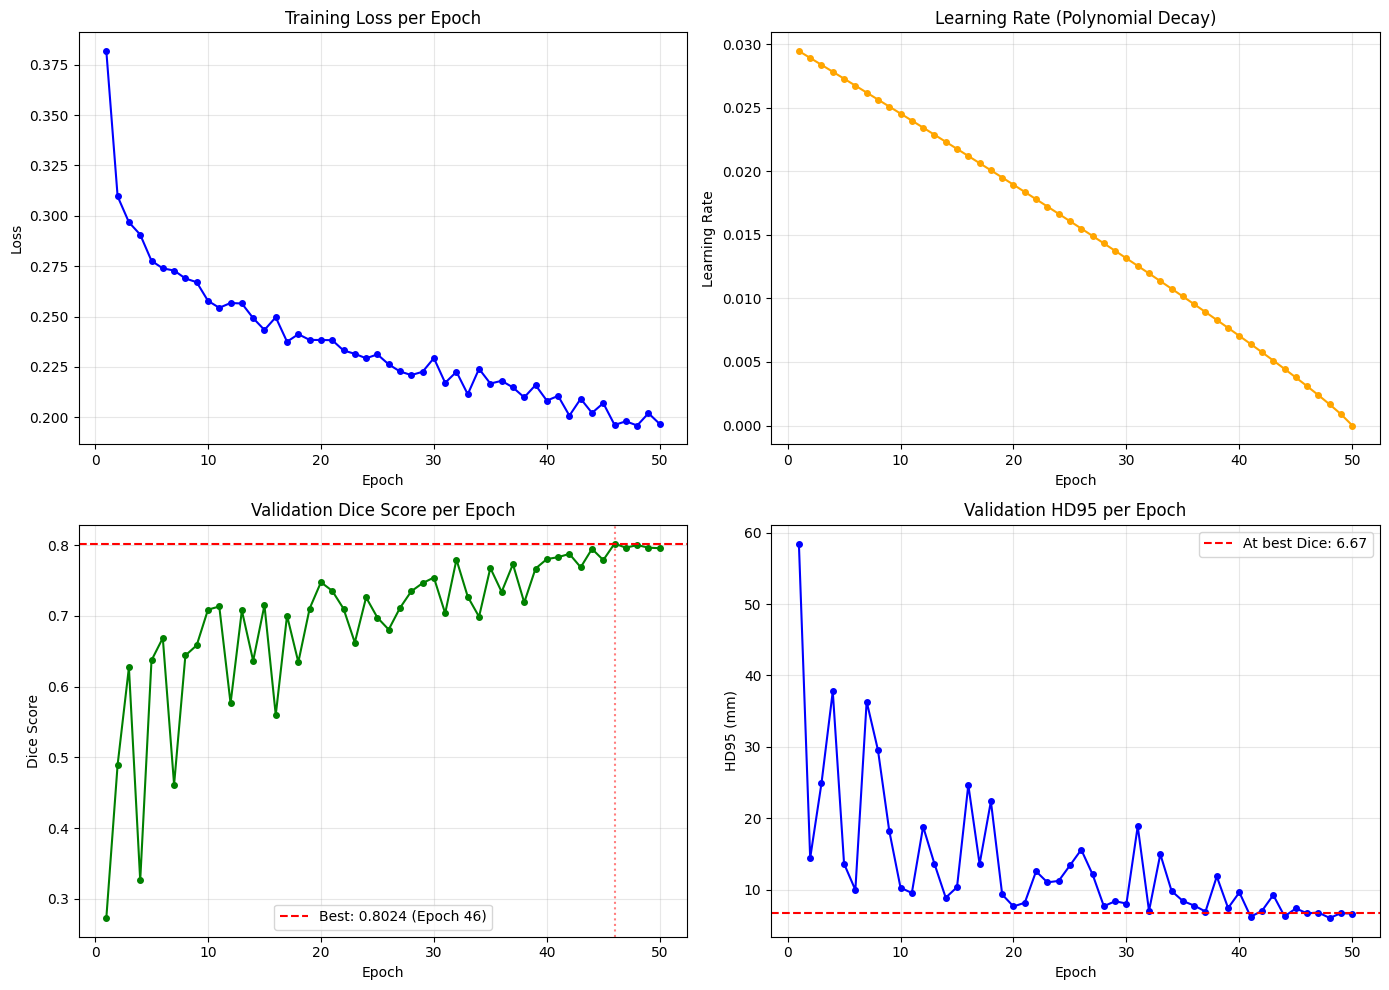


📊 Training history saved to /home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/experiments/unet_notebook/training_history.png


In [13]:
# Plot training history (epoch-based)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training Loss per epoch
if history['epoch']:
    axes[0, 0].plot(history['epoch'], history['train_loss'], 'b-o', markersize=4)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss per Epoch')
    axes[0, 0].grid(True, alpha=0.3)

    # Learning Rate
    axes[0, 1].plot(history['epoch'], history['lr'], 'orange', marker='o', markersize=4)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].set_title('Learning Rate (Polynomial Decay)')
    axes[0, 1].grid(True, alpha=0.3)

    # Validation Dice
    axes[1, 0].plot(history['epoch'], history['val_dice'], 'g-o', markersize=4)
    axes[1, 0].axhline(y=best_performance, color='r', linestyle='--', label=f'Best: {best_performance:.4f} (Epoch {best_epoch})')
    axes[1, 0].axvline(x=best_epoch, color='r', linestyle=':', alpha=0.5)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Dice Score')
    axes[1, 0].set_title('Validation Dice Score per Epoch')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Validation HD95
    axes[1, 1].plot(history['epoch'], history['val_hd95'], 'b-o', markersize=4)
    if best_epoch in history['epoch']:
        best_idx = history['epoch'].index(best_epoch)
        axes[1, 1].axhline(y=history['val_hd95'][best_idx], color='r', linestyle='--', 
                          label=f'At best Dice: {history["val_hd95"][best_idx]:.2f}')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('HD95 (mm)')
    axes[1, 1].set_title('Validation HD95 per Epoch')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(experiment_dir / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Training history saved to {experiment_dir / 'training_history.png'}")

## 13. Load Best Model và Evaluation

Load model tốt nhất và đánh giá trên validation/test set.

In [21]:
# ============================================================
# LOAD BEST MODEL
# ============================================================

experiment_dir = Path(config.experiment_dir)


def load_model(checkpoint_path: str, model: nn.Module) -> nn.Module:
    """Load model từ checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    print(f"✅ Model loaded from {checkpoint_path}")
    print(f"   Iteration: {checkpoint['iter']}")
    print(f"   Best Dice: {checkpoint['dice']:.4f}")
    return model


# Load best model
best_model_path = experiment_dir / "unet_best_model.pth"
if best_model_path.exists():
    model = load_model(str(best_model_path), model)
else:
    print("⚠️ Best model not found. Using current model.")

✅ Model loaded from /home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/experiments/unet_notebook/unet_best_model.pth
   Iteration: 60306
   Best Dice: 0.8024


## 14. Final Evaluation on Validation Set

In [22]:
# ============================================================
# FINAL EVALUATION
# ============================================================

model.eval()

print("📊 Evaluating on validation set...")
print("=" * 60)

results = []
with torch.no_grad():
    for i, val_batch in enumerate(tqdm(val_loader, desc="Evaluating")):
        name = val_batch["name"][0]
        
        metric_i = test_single_volume(
            val_batch["image"],
            val_batch["label"],
            model,
            classes=config.num_classes,
            patch_size=list(config.patch_size),
            batch_size=24
        )
        
        dice, hd95, asd = metric_i[0]  # Class 1 (foreground)
        results.append({
            'name': name,
            'dice': dice,
            'hd95': hd95,
            'asd': asd
        })
        print(f"   {name}: Dice={dice:.4f}, HD95={hd95:.2f}, ASD={asd:.2f}")

# Summary statistics
print("\n" + "=" * 60)
print("📊 VALIDATION RESULTS SUMMARY")
print("=" * 60)

dice_scores = [r['dice'] for r in results]
hd95_scores = [r['hd95'] for r in results]
asd_scores = [r['asd'] for r in results]

print(f"Dice Score: {np.mean(dice_scores):.4f} ± {np.std(dice_scores):.4f}")
print(f"HD95:       {np.mean(hd95_scores):.2f} ± {np.std(hd95_scores):.2f} mm")
print(f"ASD:        {np.mean(asd_scores):.2f} ± {np.std(asd_scores):.2f} mm")
print(f"\nTotal cases evaluated: {len(results)}")

📊 Evaluating on validation set...


Evaluating:   3%|▎         | 1/32 [00:04<02:33,  4.95s/it]

   OA_CenterA_ano_set_A_003: Dice=0.8641, HD95=3.00, ASD=0.90


Evaluating:   6%|▋         | 2/32 [00:08<02:12,  4.40s/it]

   OA_CenterA_ano_set_A_004: Dice=0.8115, HD95=6.71, ASD=2.20


Evaluating:   9%|▉         | 3/32 [00:09<01:20,  2.76s/it]

   OA_CenterA_ano_set_A_009: Dice=0.8231, HD95=6.02, ASD=2.17


Evaluating:  12%|█▎        | 4/32 [00:12<01:15,  2.71s/it]

   OA_CenterA_ano_set_A_019: Dice=0.8340, HD95=5.21, ASD=1.63


Evaluating:  16%|█▌        | 5/32 [00:16<01:24,  3.12s/it]

   OA_CenterA_ano_set_A_022: Dice=0.6718, HD95=24.63, ASD=7.21


Evaluating:  19%|█▉        | 6/32 [00:19<01:21,  3.13s/it]

   OA_CenterA_ano_set_A_035: Dice=0.8916, HD95=3.00, ASD=0.93


Evaluating:  22%|██▏       | 7/32 [00:23<01:23,  3.33s/it]

   OA_CenterA_ano_set_A_037: Dice=0.6747, HD95=10.05, ASD=3.80


Evaluating:  25%|██▌       | 8/32 [00:26<01:22,  3.45s/it]

   OA_CenterA_ano_set_A_039: Dice=0.7807, HD95=9.00, ASD=2.84


Evaluating:  28%|██▊       | 9/32 [00:29<01:11,  3.13s/it]

   OA_CenterA_ano_set_A_051: Dice=0.8013, HD95=8.60, ASD=2.34


Evaluating:  31%|███▏      | 10/32 [00:29<00:50,  2.28s/it]

   OA_CenterA_ano_set_A_052: Dice=0.8078, HD95=7.66, ASD=2.24


Evaluating:  34%|███▍      | 11/32 [00:36<01:20,  3.83s/it]

   OA_CenterB_ano_set_A_001: Dice=0.7196, HD95=17.25, ASD=5.16


Evaluating:  38%|███▊      | 12/32 [00:42<01:26,  4.33s/it]

   OA_CenterB_ano_set_A_002: Dice=0.9127, HD95=2.83, ASD=0.69


Evaluating:  41%|████      | 13/32 [00:48<01:33,  4.92s/it]

   OA_CenterB_ano_set_A_012: Dice=0.7484, HD95=8.80, ASD=2.52


Evaluating:  44%|████▍     | 14/32 [00:55<01:36,  5.37s/it]

   OA_CenterB_ano_set_A_021: Dice=0.7762, HD95=7.35, ASD=2.40


Evaluating:  47%|████▋     | 15/32 [00:59<01:28,  5.20s/it]

   OA_CenterB_ano_set_A_026: Dice=0.7173, HD95=21.04, ASD=4.98


Evaluating:  50%|█████     | 16/32 [01:04<01:20,  5.03s/it]

   OA_CenterB_ano_set_A_031: Dice=0.7986, HD95=5.41, ASD=2.21


Evaluating:  53%|█████▎    | 17/32 [01:11<01:25,  5.68s/it]

   OA_CenterB_ano_set_A_033: Dice=0.7894, HD95=6.08, ASD=1.36


Evaluating:  56%|█████▋    | 18/32 [01:17<01:18,  5.58s/it]

   OA_CenterB_ano_set_A_036: Dice=0.7973, HD95=3.04, ASD=1.10


Evaluating:  59%|█████▉    | 19/32 [01:23<01:16,  5.87s/it]

   OA_CenterB_ano_set_A_045: Dice=0.7992, HD95=4.61, ASD=1.25


Evaluating:  62%|██████▎   | 20/32 [01:31<01:18,  6.51s/it]

   OA_CenterB_ano_set_A_050: Dice=0.7411, HD95=7.81, ASD=2.10


Evaluating:  66%|██████▌   | 21/32 [01:33<00:56,  5.16s/it]

   OA_CenterC_ano_set_A_011: Dice=0.8332, HD95=4.03, ASD=0.79


Evaluating:  69%|██████▉   | 22/32 [01:35<00:42,  4.21s/it]

   OA_CenterC_ano_set_A_012: Dice=0.9031, HD95=1.58, ASD=0.33


Evaluating:  72%|███████▏  | 23/32 [01:37<00:32,  3.57s/it]

   OA_CenterC_ano_set_A_016: Dice=0.8043, HD95=3.00, ASD=0.97


Evaluating:  75%|███████▌  | 24/32 [01:39<00:24,  3.10s/it]

   OA_CenterC_ano_set_A_031: Dice=0.8254, HD95=3.91, ASD=1.07


Evaluating:  78%|███████▊  | 25/32 [01:41<00:19,  2.77s/it]

   OA_CenterC_ano_set_A_033: Dice=0.7473, HD95=4.03, ASD=1.75


Evaluating:  81%|████████▏ | 26/32 [01:43<00:15,  2.56s/it]

   OA_CenterC_ano_set_A_039: Dice=0.8402, HD95=3.67, ASD=0.91


Evaluating:  84%|████████▍ | 27/32 [01:45<00:12,  2.41s/it]

   OA_CenterC_ano_set_A_040: Dice=0.8734, HD95=3.00, ASD=0.82


Evaluating:  88%|████████▊ | 28/32 [01:47<00:09,  2.29s/it]

   OA_CenterC_ano_set_A_050: Dice=0.8417, HD95=4.27, ASD=4.06


Evaluating:  91%|█████████ | 29/32 [01:49<00:06,  2.20s/it]

   OA_CenterC_ano_set_A_052: Dice=0.7353, HD95=6.00, ASD=1.05


Evaluating:  94%|█████████▍| 30/32 [01:51<00:04,  2.16s/it]

   OA_CenterC_ano_set_A_053: Dice=0.8788, HD95=3.00, ASD=0.77


Evaluating:  97%|█████████▋| 31/32 [01:53<00:02,  2.11s/it]

   OA_CenterC_ano_set_A_054: Dice=0.8504, HD95=3.00, ASD=1.98


Evaluating: 100%|██████████| 32/32 [01:54<00:00,  3.59s/it]

   OA_CenterC_ano_set_A_057: Dice=0.7816, HD95=6.00, ASD=1.54

📊 VALIDATION RESULTS SUMMARY
Dice Score: 0.8024 ± 0.0604
HD95:       6.67 ± 5.15 mm
ASD:        2.06 ± 1.50 mm

Total cases evaluated: 32


## 15. Visualize Predictions

Hiển thị một số dự đoán trên validation set.

🎨 Visualizing predictions...


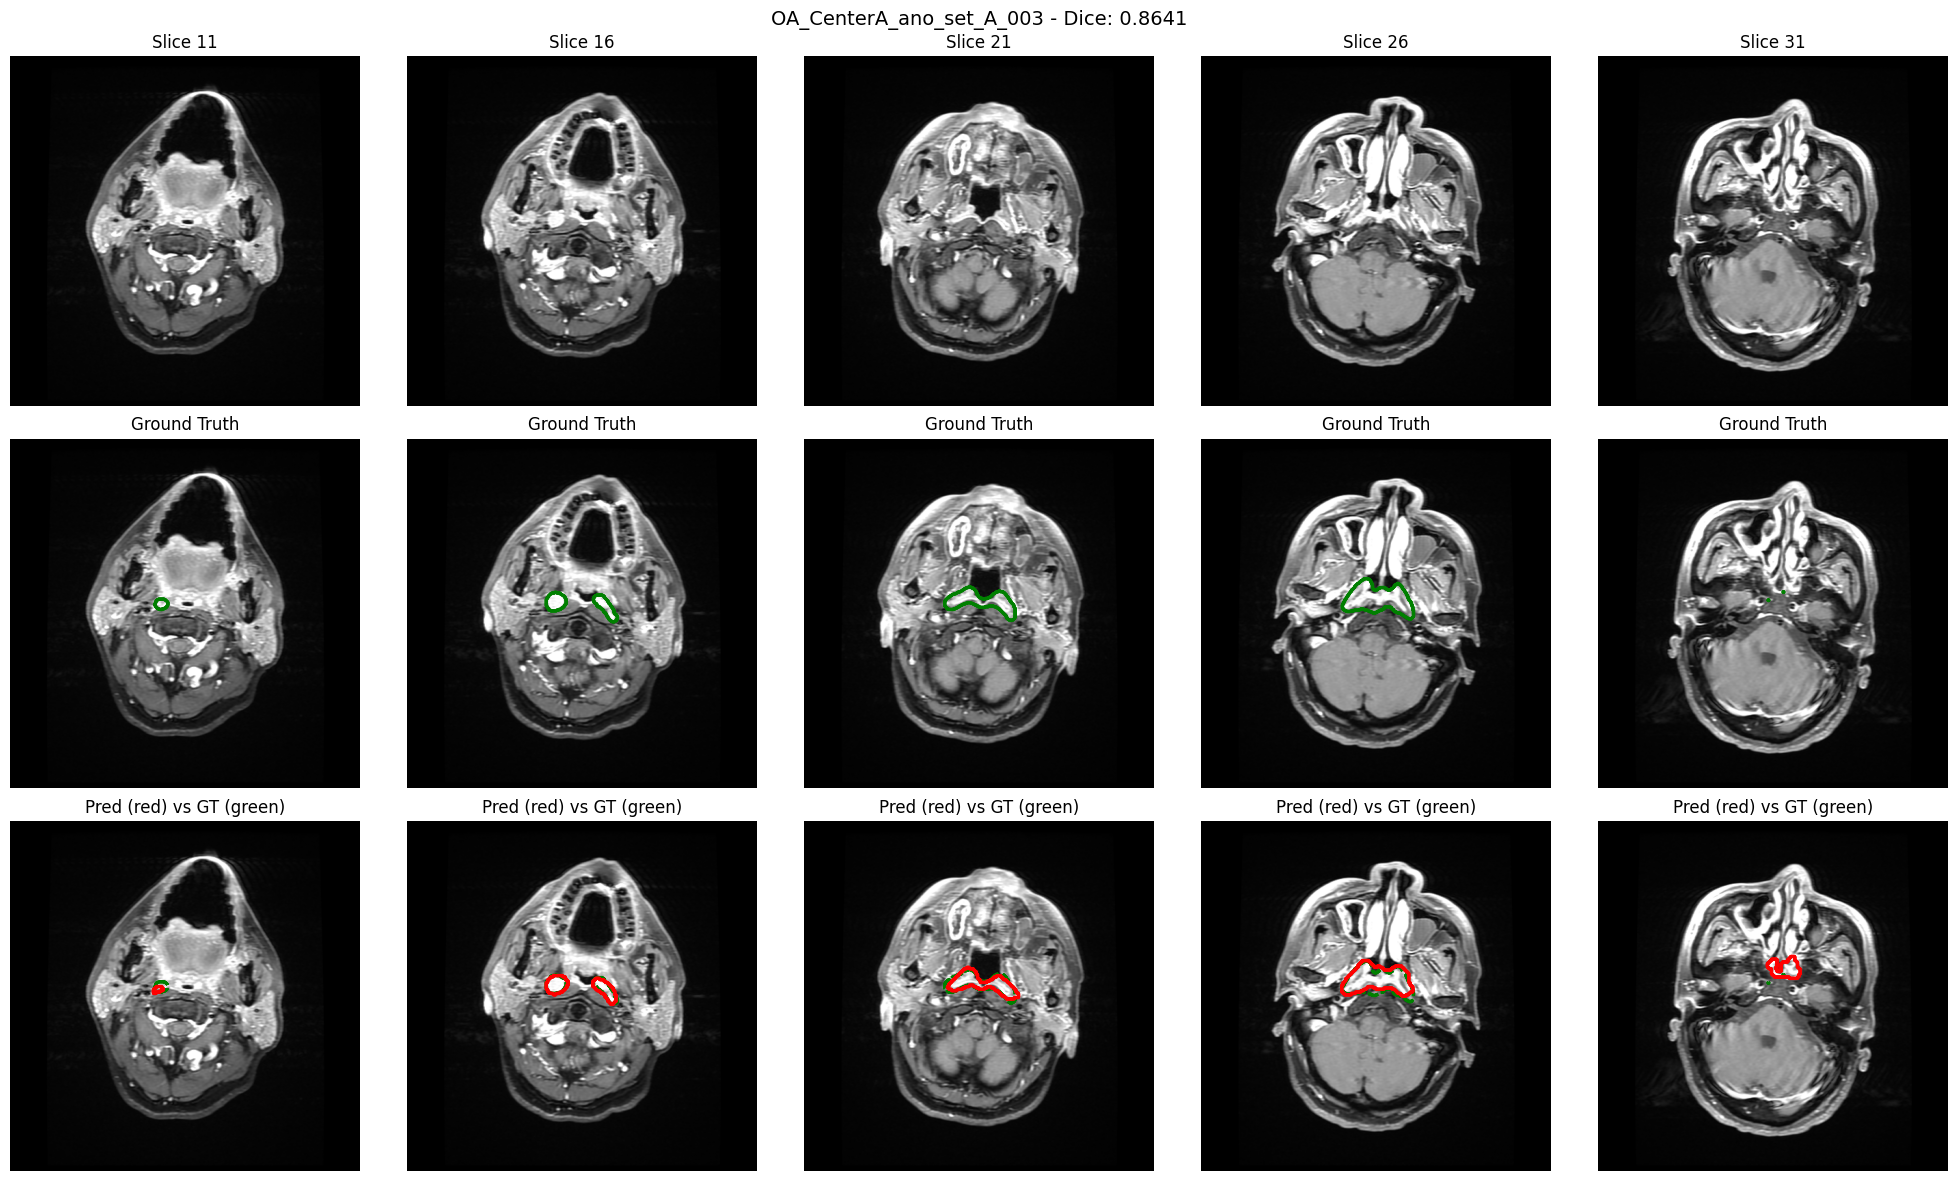

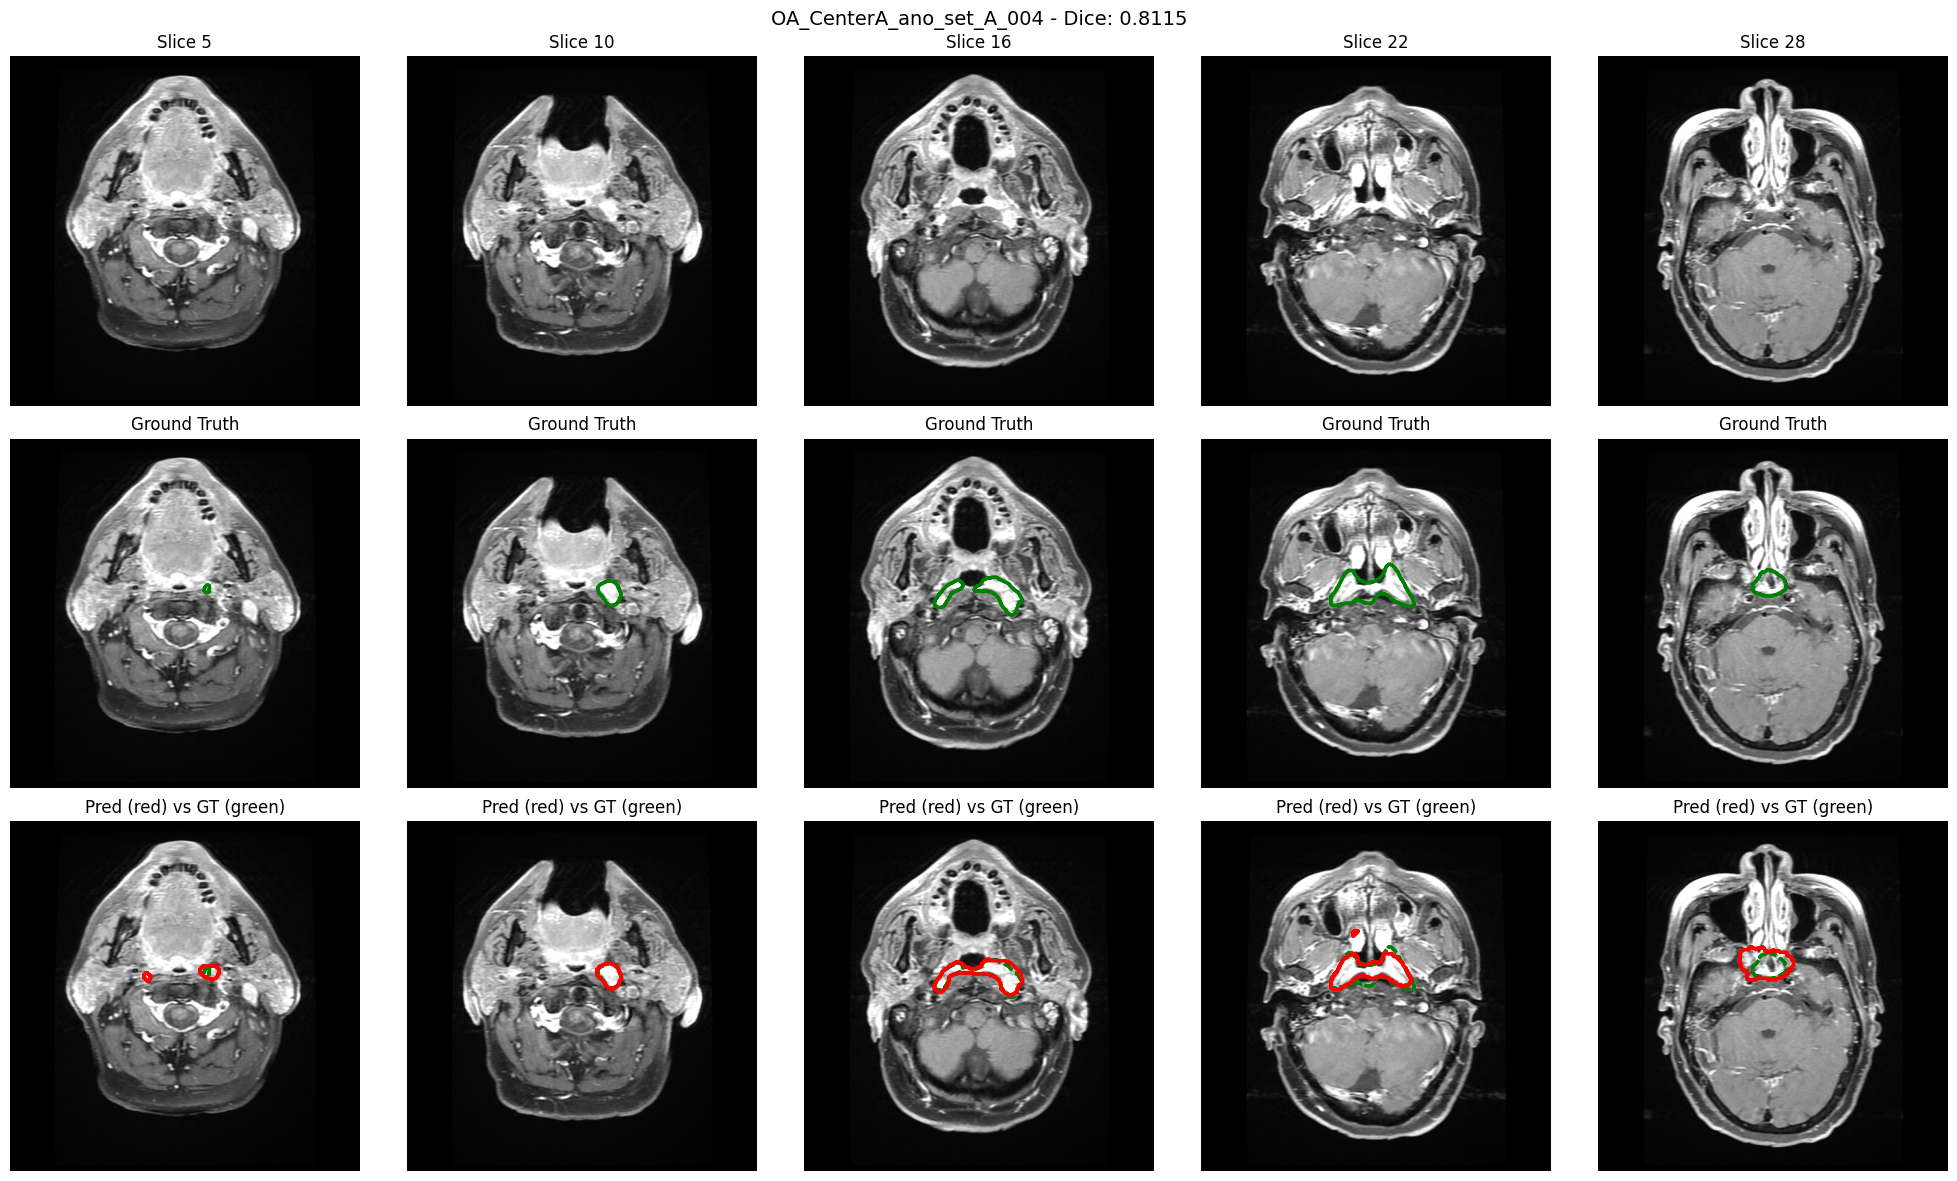

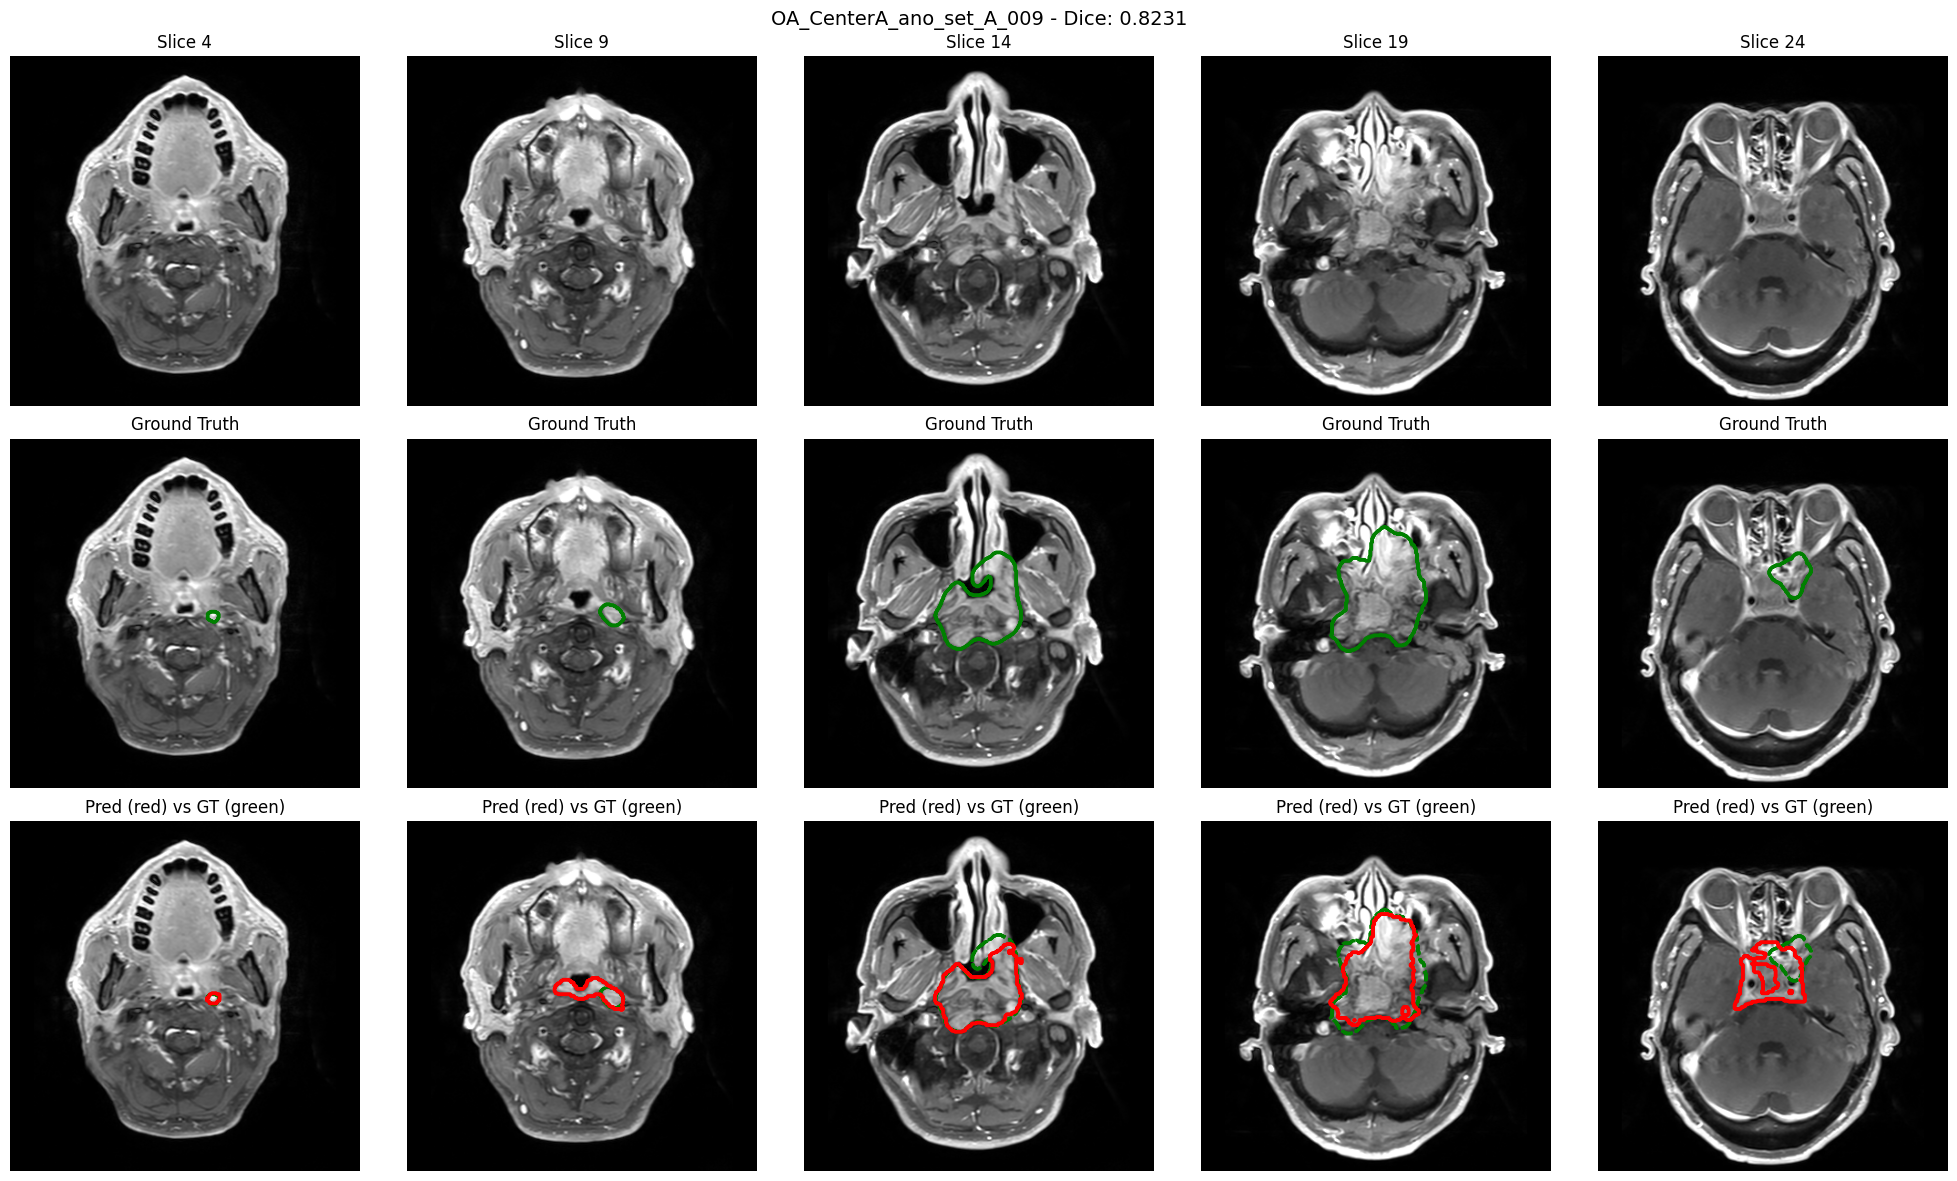


✅ Predictions saved to /home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/experiments/unet_notebook


In [23]:
def visualize_prediction(image: np.ndarray, label: np.ndarray, prediction: np.ndarray, 
                          title: str = "", num_slices: int = 5):
    """
    Visualize prediction với image, ground truth và prediction
    
    Args:
        image: (D, H, W)
        label: (D, H, W)
        prediction: (D, H, W)
        title: Title cho figure
        num_slices: Số slices hiển thị
    """
    # Chọn các slices có tumor
    tumor_slices = np.where(label.sum(axis=(1, 2)) > 0)[0]
    if len(tumor_slices) == 0:
        tumor_slices = np.arange(0, image.shape[0], image.shape[0] // num_slices)
    
    # Chọn num_slices slices đều nhau
    if len(tumor_slices) > num_slices:
        indices = np.linspace(0, len(tumor_slices) - 1, num_slices, dtype=int)
        selected_slices = tumor_slices[indices]
    else:
        selected_slices = tumor_slices
    
    fig, axes = plt.subplots(3, len(selected_slices), figsize=(4 * len(selected_slices), 12))
    
    for i, slice_idx in enumerate(selected_slices):
        # Image
        axes[0, i].imshow(image[slice_idx], cmap='gray')
        axes[0, i].set_title(f'Slice {slice_idx}')
        axes[0, i].axis('off')
        
        # Ground Truth
        axes[1, i].imshow(image[slice_idx], cmap='gray')
        axes[1, i].contour(label[slice_idx], colors='green', linewidths=2)
        axes[1, i].set_title('Ground Truth')
        axes[1, i].axis('off')
        
        # Prediction
        axes[2, i].imshow(image[slice_idx], cmap='gray')
        axes[2, i].contour(label[slice_idx], colors='green', linewidths=2, linestyles='--')
        axes[2, i].contour(prediction[slice_idx], colors='red', linewidths=2)
        axes[2, i].set_title('Pred (red) vs GT (green)')
        axes[2, i].axis('off')
    
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    return fig


# Predict và visualize một vài cases
print("🎨 Visualizing predictions...")

model.eval()
num_viz = min(3, len(val_dataset))

for i in range(num_viz):
    sample = val_dataset[i]
    image = sample['image'].numpy().squeeze()  # (D, H, W)
    label = sample['label'].numpy()            # (D, H, W)
    name = sample['name']
    
    # Predict
    prediction = np.zeros_like(label)
    with torch.no_grad():
        for ind in range(0, image.shape[0], 24):
            end_ind = min(ind + 24, image.shape[0])
            stacked = image[ind:end_ind]
            z, x, y = stacked.shape
            
            zoomed = zoom(stacked, (1, config.patch_size[0]/x, config.patch_size[1]/y), order=0)
            input_tensor = torch.from_numpy(zoomed).unsqueeze(1).float().to(device)
            
            out = torch.argmax(torch.softmax(model(input_tensor), dim=1), dim=1)
            out = out.cpu().numpy()
            
            pred = zoom(out, (1, x/config.patch_size[0], y/config.patch_size[1]), order=0)
            prediction[ind:end_ind] = pred
    
    # Calculate metrics
    dice = metric.binary.dc(prediction > 0, label > 0)
    
    # Visualize
    fig = visualize_prediction(image, label, prediction, 
                                title=f"{name} - Dice: {dice:.4f}")
    plt.show()
    
    # Save figure
    fig.savefig(experiment_dir / f'prediction_{name}.png', dpi=150, bbox_inches='tight')
    plt.close(fig)

print(f"\n✅ Predictions saved to {experiment_dir}")

## 16. Test Set Evaluation (Optional)

Đánh giá trên test set nếu có.

In [24]:
# ============================================================
# TEST SET EVALUATION
# ============================================================

test_dir = Path(config.output_root) / "test_set"

if test_dir.exists() and len(list(test_dir.glob("*.h5"))) > 0:
    print("📊 Evaluating on test set...")
    print("=" * 60)
    
    test_dataset = H5VolumeDataset(test_dir)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)
    
    test_results = []
    model.eval()
    
    with torch.no_grad():
        for i, test_batch in enumerate(tqdm(test_loader, desc="Testing")):
            name = test_batch["name"][0]
            
            metric_i = test_single_volume(
                test_batch["image"],
                test_batch["label"],
                model,
                classes=config.num_classes,
                patch_size=list(config.patch_size),
                batch_size=24
            )
            
            dice, hd95, asd = metric_i[0]
            test_results.append({
                'name': name,
                'dice': dice,
                'hd95': hd95,
                'asd': asd
            })
            print(f"   {name}: Dice={dice:.4f}, HD95={hd95:.2f}, ASD={asd:.2f}")
    
    # Summary
    print("\n" + "=" * 60)
    print("📊 TEST RESULTS SUMMARY")
    print("=" * 60)
    
    test_dice = [r['dice'] for r in test_results]
    test_hd95 = [r['hd95'] for r in test_results]
    test_asd = [r['asd'] for r in test_results]
    
    print(f"Dice Score: {np.mean(test_dice):.4f} ± {np.std(test_dice):.4f}")
    print(f"HD95:       {np.mean(test_hd95):.2f} ± {np.std(test_hd95):.2f} mm")
    print(f"ASD:        {np.mean(test_asd):.2f} ± {np.std(test_asd):.2f} mm")
    print(f"\nTotal test cases: {len(test_results)}")
else:
    print("⚠️ Test set not found. Skipping test evaluation.")

📊 Evaluating on test set...


Testing:   6%|▋         | 1/16 [00:00<00:13,  1.13it/s]

   OA_CenterA_ano_set_A_005: Dice=0.8399, HD95=4.61, ASD=2.79


Testing:  12%|█▎        | 2/16 [00:05<00:40,  2.88s/it]

   OA_CenterA_ano_set_A_006: Dice=0.8560, HD95=4.24, ASD=0.84


Testing:  19%|█▉        | 3/16 [00:07<00:36,  2.84s/it]

   OA_CenterA_ano_set_A_024: Dice=0.8836, HD95=3.00, ASD=0.62


Testing:  25%|██▌       | 4/16 [00:08<00:23,  1.99s/it]

   OA_CenterA_ano_set_A_030: Dice=0.7739, HD95=12.00, ASD=3.18


Testing:  31%|███▏      | 5/16 [00:15<00:40,  3.72s/it]

   OA_CenterA_ano_set_A_038: Dice=0.8046, HD95=7.87, ASD=3.04


Testing:  38%|███▊      | 6/16 [00:22<00:47,  4.74s/it]

   OA_CenterB_ano_set_A_016: Dice=0.8347, HD95=6.00, ASD=2.21


Testing:  44%|████▍     | 7/16 [00:29<00:49,  5.51s/it]

   OA_CenterB_ano_set_A_018: Dice=0.8099, HD95=4.92, ASD=1.60


Testing:  50%|█████     | 8/16 [00:37<00:51,  6.45s/it]

   OA_CenterB_ano_set_A_024: Dice=0.7461, HD95=15.43, ASD=3.86


Testing:  56%|█████▋    | 9/16 [00:45<00:47,  6.82s/it]

   OA_CenterB_ano_set_A_029: Dice=0.8323, HD95=3.39, ASD=0.95


Testing:  62%|██████▎   | 10/16 [00:51<00:39,  6.64s/it]

   OA_CenterB_ano_set_A_046: Dice=0.8190, HD95=6.26, ASD=2.44


Testing:  69%|██████▉   | 11/16 [00:53<00:25,  5.05s/it]

   OA_CenterC_ano_set_A_001: Dice=0.8647, HD95=3.00, ASD=0.55


Testing:  75%|███████▌  | 12/16 [00:56<00:17,  4.44s/it]

   OA_CenterC_ano_set_A_014: Dice=0.6606, HD95=10.00, ASD=3.53


Testing:  81%|████████▏ | 13/16 [00:56<00:10,  3.36s/it]

   OA_CenterC_ano_set_A_015: Dice=0.8522, HD95=3.04, ASD=0.63


Testing:  88%|████████▊ | 14/16 [00:58<00:05,  2.95s/it]

   OA_CenterC_ano_set_A_023: Dice=0.8605, HD95=3.00, ASD=0.84


Testing:  94%|█████████▍| 15/16 [01:01<00:02,  2.85s/it]

   OA_CenterC_ano_set_A_029: Dice=0.8217, HD95=3.91, ASD=1.79


Testing: 100%|██████████| 16/16 [01:04<00:00,  4.00s/it]

   OA_CenterC_ano_set_A_042: Dice=0.7988, HD95=3.04, ASD=1.62

📊 TEST RESULTS SUMMARY
Dice Score: 0.8162 ± 0.0526
HD95:       5.86 ± 3.59 mm
ASD:        1.91 ± 1.09 mm

Total test cases: 16


## 17. Summary và Next Steps

### Kết quả đạt được:
- ✅ Chuyển đổi dữ liệu NIfTI sang HDF5
- ✅ Training U-Net model
- ✅ Đánh giá với Dice, HD95, ASD metrics
- ✅ Lưu best model và checkpoints

### Files được tạo:
- `outputs/h5_dataset/` - Dữ liệu HDF5
- `outputs/experiments/unet_notebook/` - Checkpoints và logs

### Next Steps:
1. Fine-tune hyperparameters
2. Thử các augmentation khác
3. Đánh giá trên nhiều centers khác nhau
4. Export model cho inference

In [25]:
# Final summary
print("=" * 60)
print("🎉 PIPELINE COMPLETE")
print("=" * 60)
print(f"\n📁 Output directories:")
print(f"   Data: {config.output_root}")
print(f"   Experiments: {config.experiment_dir}")
print(f"\n📊 Final Results:")
print(f"   Best Epoch: {best_epoch}")
print(f"   Best Validation Dice: {best_performance:.4f}")
print(f"   Total epochs trained: {epoch_num}")
print(f"   Total iterations: {iter_num}")
print(f"\n💾 Saved models:")
print(f"   Best: {experiment_dir / 'unet_best_model.pth'}")
print(f"   Last: {experiment_dir / 'last_model.pth'}")
print("\n✅ All done!")

🎉 PIPELINE COMPLETE

📁 Output directories:
   Data: /home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/h5_dataset
   Experiments: /home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/experiments/unet_notebook

📊 Final Results:
   Best Epoch: 0
   Best Validation Dice: 0.0000


NameError: name 'epoch_num' is not defined

# train theo interation có thể bắt đtdduowcbest pont tốt hơn

In [ ]:
# ============================================================
# RESUME TRAINING FROM CHECKPOINT
# ============================================================

def resume_training(checkpoint_path: str, model: nn.Module, optimizer: optim.Optimizer, 
                    config: Config) -> Tuple[int, int, float]:
    """
    Load checkpoint và resume training
    
    Args:
        checkpoint_path: Đường dẫn tới checkpoint file (.pth)
        model: Model đã khởi tạo
        optimizer: Optimizer đã khởi tạo
        config: Config object
        
    Returns:
        Tuple of (start_epoch, iter_num, best_performance)
    """
    if not Path(checkpoint_path).exists():
        print(f"⚠️ Checkpoint not found: {checkpoint_path}")
        print("   Starting training from scratch...")
        return 1, 0, 0.0
    
    print(f"🔄 Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load model state
    model.load_state_dict(checkpoint['state_dict'])
    
    # Load optimizer state
    if 'optimizer' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("   ✅ Optimizer state loaded")
    
    # Extract training state
    start_epoch = checkpoint.get('epoch', 0) + 1  # Start from next epoch
    iter_num = checkpoint.get('iter', 0)
    best_performance = checkpoint.get('dice', 0.0)
    
    print(f"   ✅ Model loaded successfully!")
    print(f"   📊 Resume from: Epoch {start_epoch}, Iteration {iter_num}")
    print(f"   📊 Best Dice so far: {best_performance:.4f}")
    
    # Restore learning rate based on iteration
    total_iterations = config.max_epochs * len(train_loader)
    lr_ = config.base_lr * (1.0 - iter_num / total_iterations) ** 0.9
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_
    print(f"   📊 Current learning rate: {lr_:.6f}")
    
    return start_epoch, iter_num, best_performance


# ============================================================
# OPTION 1: Resume from last checkpoint
# ============================================================
# Uncomment để resume training từ checkpoint cuối cùng

# checkpoint_to_resume = experiment_dir / "last_model.pth"
# start_epoch, iter_num, best_performance = resume_training(
#     str(checkpoint_to_resume), model, optimizer, config
# )

# ============================================================
# OPTION 2: Resume from best model
# ============================================================
# Uncomment để resume training từ best model

# checkpoint_to_resume = experiment_dir / "unet_best_model.pth"
# start_epoch, iter_num, best_performance = resume_training(
#     str(checkpoint_to_resume), model, optimizer, config
# )

# ============================================================
# OPTION 3: Resume from specific epoch checkpoint
# ============================================================
# Uncomment và thay đổi epoch number

# epoch_to_resume = 30
# checkpoint_to_resume = experiment_dir / f"model_epoch_{epoch_to_resume}.pth"
# start_epoch, iter_num, best_performance = resume_training(
#     str(checkpoint_to_resume), model, optimizer, config
# )

print("\n" + "=" * 60)
print("💡 Để resume training, uncomment một trong các options ở trên")
print("   rồi chạy lại cell Training Loop")
print("=" * 60)

In [ ]:
# ...existing code...
@dataclass
class Config:
    """Cấu hình cho toàn bộ pipeline"""
    
    # === Đường dẫn dữ liệu ===
    dataset_root: str = "/home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/TMI2024_SFADA_GTV_Seg-20251026T074626Z-1-001/TMI2024_SFADA_GTV_Seg"
    output_root: str = "/home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/h5_dataset"
    experiment_dir: str = "/home/ubuntu/Documents/Source_NPC/SFADA-GTV-Seg/New_Code/notebooks/outputs/experiments/unet_notebook"
    
    # === Tiền xử lý dữ liệu ===
    clip_percentile: float = 0.99
    train_ratio: float = 0.7
    val_ratio: float = 0.2
    test_ratio: float = 0.1
    
    # === Training (UPDATED to match train_unet.py / Code_OA) ===
    batch_size: int = 32          # Tăng từ 4 lên 32 
    num_workers: int = 16         #  Tăng từ 4 lên 16 
    max_iterations: int = 12000   # Thay max_epochs bằng max_iterations
    base_lr: float = 0.03
    weight_decay: float = 1e-4
    
    # === Model ===
    num_classes: int = 2
    patch_size: Tuple[int, int] = (256, 256)
    
    # === Evaluation (UPDATED to match Code_OA) ===
    eval_every_iter: int = 100    #  Đánh giá mỗi 100 iterations (không phải epochs)
    save_every_iter: int = 3000   #  Lưu checkpoint mỗi 3000 iterations
    patience: int = 0             #  Disable early stopping (giống Code_OA)
    
    # === Misc ===
    seed: int = 2023
    device: str = "cuda"
# ...existing code...